In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sparse_stoch_mat_central as sp_stoch_mat
import sys
from scipy.sparse.linalg import spsolve
import timeit
#sys.path.append('/home/hcleroy/Extra_Module_py/')
#from formated_matplotlib import *
from functions import *
from phys_functions import physfcts 

## Equation differential of the problem :
^ wtf this is French accent
$$ 
\begin{cases}
&\partial_t \rho_a = \partial_x^2 \rho_a +\partial_x[\rho_a \partial_x V_a] + \rho_b k_{ba} + \rho_c k_{ca} - \rho_a(k_{ac}+k_{ab})\\
&\partial_t \rho_b = \partial_x^2 \rho_b +\partial_x[\rho_b \partial_x V_b] + \rho_a k_{ab} + \rho_c k_{cb} - \rho_b(k_{bc}+k_{ba})\\
&\partial_t \rho_c = \partial_x^2 \rho_c +\partial_x[\rho_c \partial_x V_c] + \rho_a k_{ac} + \rho_b k_{bc} - \rho_c(k_{ca}+k_{cb})\\
\end{cases}
$$
with :
$$
\begin{cases}
&k_{ab} = k_{ab}^0 e^{-\epsilon_{ab}+V_a}A_{ab} \hspace{1cm} k_{bc} = k_{bc}^0e^{-\text{max}(V_c-V_b,0)+\epsilon_{bc}}A_{bc} \hspace{1cm} k_{ac} = k_{ac}^0 e^{-\text{max}(V_c-V_a,0)+\epsilon_{ac}}A_{ac}\\
&k_{ba} = k_{ab}^0 e^{-\text{max}(V_a-V_b,0)+\epsilon_{ab}} \hspace{1cm} k_{cb} = k_{bc}^0e^{-\text{max}(V_b-V_c,0)+\epsilon_{bc}} \hspace{1cm} k_{ca} = k_{ac}^0 e^{-\text{max}(V_a-V_c,0)+\epsilon_{ac}}
\end{cases}
$$
Where $V_a$, $V_b$, and $V_c$ are the space dependent potential that affect respectively $a$, $b$, $c$, $A_{ab}$, $A_{bc}$, $A_{ac}$ are respectively the activity brought to the reaction $a\rightarrow b$, $b\rightarrow c$, $a\rightarrow c$. the $k^0$ will define time units.

In [78]:
eta = 0.0001
V0a, V0b, V0c = 0.,0.,0.
V1a, V1b, V1c = .5,1.,1.5
signA, signB, signC = 1,1,1
per = 1
Eab0,Ebc0,Eac0 = .5,.7,1. 
kab0,kbc0,kac0 = 1.,1.,1. 
mu = 1.5
Aab,Abc,Aac = 1.,1.,mu # != 1 -> ooe
# is my stuff in equilibrium?..
X0,Xf,n = -1,1,10000 # lower/higher spacial boundary and number of discretizing points
dx = (Xf-X0)/n
print('dx = '+str(dx))

X = np.linspace(X0,Xf,n,endpoint=False)
Xfull = np.linspace(X0,Xf,n)



dx = 0.0002


In [3]:
vars = np.array([eta, kab0, kbc0, kac0, Eab0, Ebc0, Eac0, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, Aac, signA, signB, signC, per, X0, Xf, n, dx])
f = physfcts(vars)


## Testing zone

In [4]:

Eab_old = lambda x: Eab0 + eta* (V1a*np.exp(V0a)+V1b*np.exp(V0b)) * (np.sin(np.pi*x/(2*Xf)))
Ebc_old = lambda x: Ebc0 + eta* (V1b*np.exp(V0b)+V1c*np.exp(V0c)) * (np.sin(np.pi*x/(2*Xf)))
Eac_old = lambda x: Eac0 + eta* (V1a*np.exp(V0a)+V1c*np.exp(V0c)) * (np.sin(np.pi*x/(2*Xf)))


# define all the Vs :
Va_old = lambda x : V0a + eta* signA*(np.sin(np.pi*x/(2*Xf))) * V1a
Vb_old = lambda x : V0b + eta* signB*(np.sin(np.pi*x/(2*Xf))) * V1b
Vc_old = lambda x : V0c + eta* signC*(np.sin(np.pi*x/(2*Xf))) * V1c

# define all the k's
kab_old = lambda X,*arg : np.array([kab0 * np.exp(-Eab_old(x)+Va_old(x))*arg[0] for x in X]) if type(X) == np.ndarray else kab0 * np.exp(-Eab_old(X)+Va_old(X))*arg[0] # arg is the activity
kba_old = lambda X,*arg : np.array([kab0 * np.exp(-Eab_old(x)+Vb_old(x))for x in X]) if type(X)==np.ndarray else kab0 * np.exp(-Eab_old(X)+Vb_old(X))# no activity but it takes the same argument as kab
kbc_old = lambda X,*arg : np.array([kbc0 * np.exp(-Ebc_old(x)+Vb_old(x))*arg[0]for x in X]) if type(X)==np.ndarray else kbc0 * np.exp(-Ebc_old(X)+Vb_old(X))*arg[0]# arg is the activity
kcb_old = lambda X,*arg : np.array([kbc0 * np.exp(-Ebc_old(x)+Vc_old(x))for x in X]) if type(X) == np.ndarray else kbc0 * np.exp(-Ebc_old(X)+Vc_old(X))# no activity but it takes the same argument as kbc
kac_old = lambda X,*arg : np.array([kac0 * np.exp(-Eac_old(x)+Va_old(x))*arg[0]for x in X]) if type(X) ==np.ndarray else kac0 * np.exp(-Eac_old(X)+Va_old(X))*arg[0]# arg is the activity
kca_old = lambda X,*arg : np.array([kac0 * np.exp(-Eac_old(x)+Vc_old(x))for x in X]) if type(X) == np.ndarray else kac0 * np.exp(-Eac_old(X)+Vc_old(X))# no activity but it takes the same argument as kac

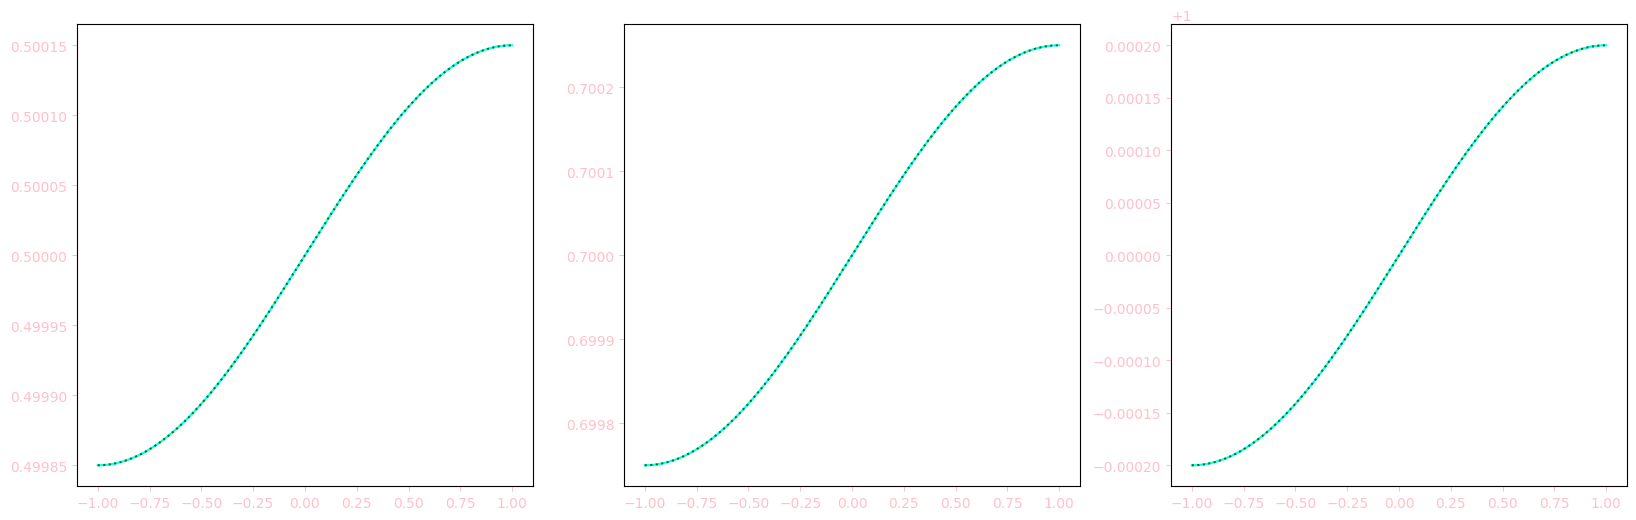

In [5]:
fig,ax = plt.subplots(ncols=3,figsize=(20,6))
ColorCycle = np.array(['red','blue', 'green', 'cyan', 'black','gray'])

ax[0].plot(X ,Eab_old(X), color = ColorCycle[3])
ax[0].plot(X ,f.Eab(X), linestyle = ":", color = ColorCycle[2])

ax[1].plot(X, Ebc_old(X), color = ColorCycle[3])
ax[1].plot(X ,f.Ebc(X), linestyle = ":", color = ColorCycle[2])

ax[2].plot(X, Eac_old(X), color = ColorCycle[3])
ax[2].plot(X ,f.Eac(X), linestyle = ":", color = ColorCycle[2])


for j in range(3):
    ax[j].tick_params(axis='x', colors='pink')
    ax[j].tick_params(axis='y', colors='pink')

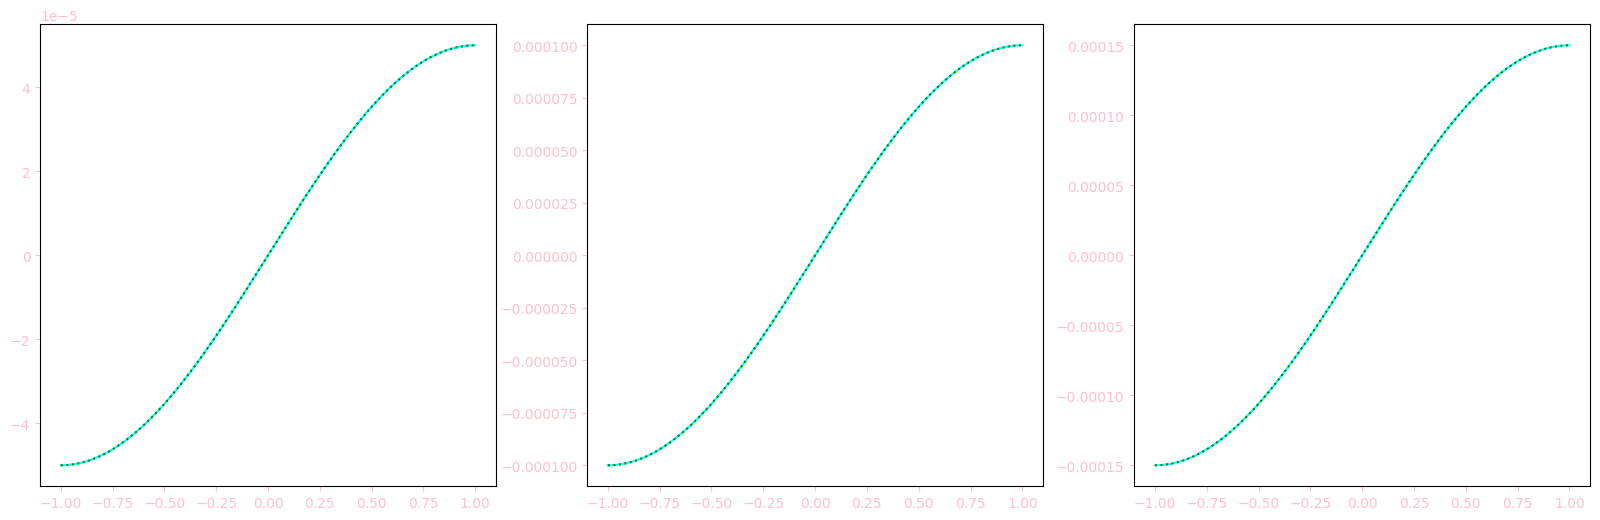

In [6]:
fig,ax = plt.subplots(ncols=3,figsize=(20,6))
ColorCycle = np.array(['red','blue', 'green', 'cyan', 'black','gray'])

ax[0].plot(X ,Va_old(X), color = ColorCycle[3])
ax[0].plot(X ,f.Va_out(X), linestyle = ":", color = ColorCycle[2])

ax[1].plot(X, Vb_old(X), color = ColorCycle[3])
ax[1].plot(X ,f.Vb_out(X), linestyle = ":", color = ColorCycle[2])

ax[2].plot(X, Vc_old(X), color = ColorCycle[3])
ax[2].plot(X ,f.Vc_out(X), linestyle = ":", color = ColorCycle[2])


for j in range(3):
    ax[j].tick_params(axis='x', colors='pink')
    ax[j].tick_params(axis='y', colors='pink')

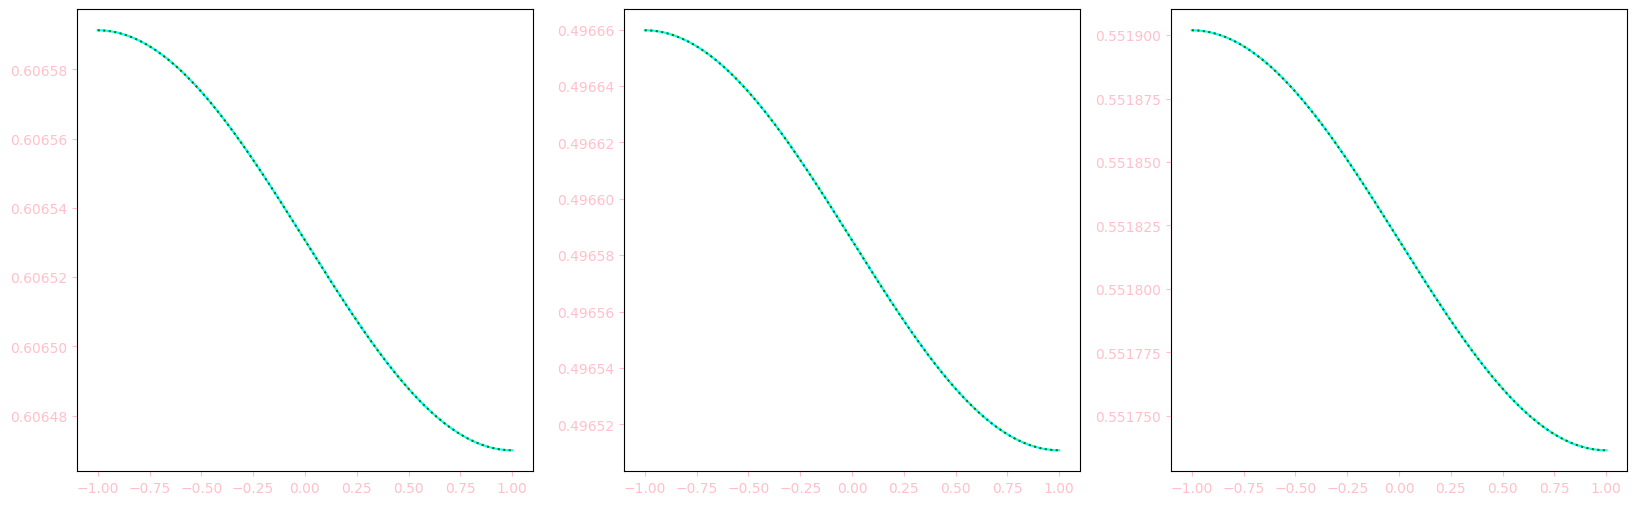

In [7]:
fig,ax = plt.subplots(ncols=3,figsize=(20,6))
ColorCycle = np.array(['red','blue', 'green', 'cyan', 'black','gray'])

ax[0].plot(X ,kab_old(X,Aab), color = ColorCycle[3])
ax[0].plot(X ,f.kab_out(X,Aab), linestyle = ":", color = ColorCycle[2])

ax[1].plot(X, kbc_old(X,Abc), color = ColorCycle[3])
ax[1].plot(X ,f.kbc_out(X,Abc), linestyle = ":", color = ColorCycle[2])

ax[2].plot(X, kac_old(X,Aac), color = ColorCycle[3])
ax[2].plot(X ,f.kac_out(X,Aac), linestyle = ":", color = ColorCycle[2])


for j in range(3):
    ax[j].tick_params(axis='x', colors='pink')
    ax[j].tick_params(axis='y', colors='pink')

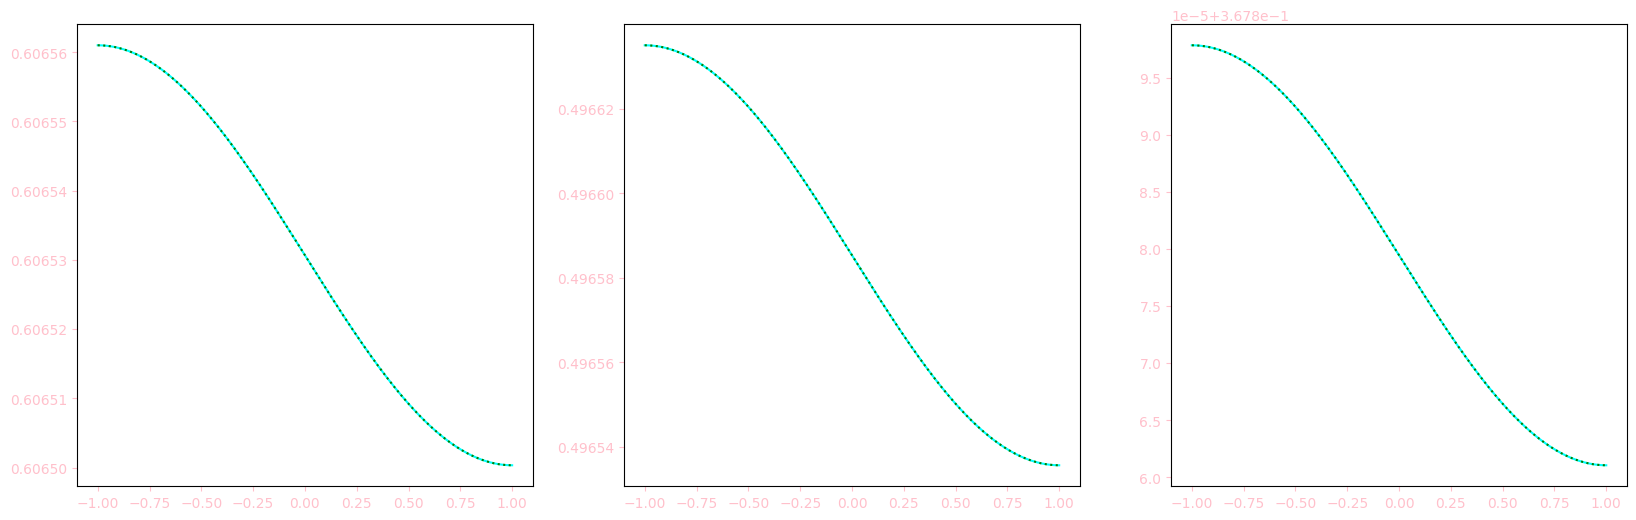

In [8]:
fig,ax = plt.subplots(ncols=3,figsize=(20,6))
ColorCycle = np.array(['red','blue', 'green', 'cyan', 'black','gray'])

ax[0].plot(X ,kba_old(X,Aab), color = ColorCycle[3])
ax[0].plot(X ,f.kba_out(X), linestyle = ":", color = ColorCycle[2])

ax[1].plot(X, kcb_old(X,Abc), color = ColorCycle[3])
ax[1].plot(X ,f.kcb_out(X), linestyle = ":", color = ColorCycle[2])

ax[2].plot(X, kca_old(X), color = ColorCycle[3])
ax[2].plot(X ,f.kca_out(X), linestyle = ":", color = ColorCycle[2])


for j in range(3):
    ax[j].tick_params(axis='x', colors='pink')
    ax[j].tick_params(axis='y', colors='pink')

In [9]:
print("Eab", f.Eab(np.linspace(0,1)))
print("num rhos", f.NumRhos())
print("math rhos", f.MathRhos(np.linspace(0,1)))

Eab [0.5        0.50000481 0.50000961 0.5000144  0.50001918 0.50002394
 0.50002867 0.50003338 0.50003805 0.50004268 0.50004727 0.5000518
 0.50005629 0.50006072 0.50006508 0.50006938 0.50007361 0.50007776
 0.50008183 0.50008582 0.50008972 0.50009352 0.50009723 0.50010085
 0.50010435 0.50010775 0.50011104 0.50011422 0.50011727 0.50012021
 0.50012303 0.50012571 0.50012827 0.5001307  0.50013299 0.50013515
 0.50013716 0.50013904 0.50014077 0.50014236 0.5001438  0.50014509
 0.50014624 0.50014723 0.50014808 0.50014877 0.50014931 0.50014969
 0.50014992 0.50015   ]
num rhos (array([0.14636912, 0.14636912, 0.14636912, ..., 0.14635475, 0.14635475,
       0.14635475]), array([0.16528795, 0.16528795, 0.16528795, ..., 0.16525435, 0.16525435,
       0.16525435]), array([0.18839501, 0.18839501, 0.18839501, ..., 0.18833881, 0.18833881,
       0.18833881]))
math rhos (array([0.14636194, 0.14636168, 0.14636141, 0.14636115, 0.14636088,
       0.14636062, 0.14636036, 0.1463601 , 0.14635984, 0.14635958,
   

## Back to code

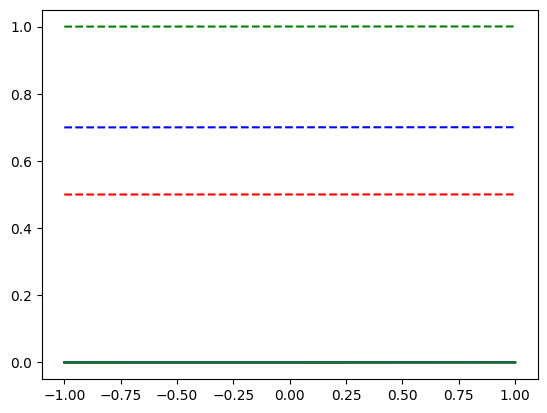

In [10]:
ColorCycle = np.array(['red','blue', 'green', 'cyan', 'black','gray'])
plt.plot(X,f.Va_out(X),'r')
plt.plot(X,f.Vb_out(X),'b')
plt.plot(X,f.Vc_out(X),'g')
plt.plot(X,f.Eab(X),'r--')
plt.plot(X,f.Ebc(X),'b--')
plt.plot(X,f.Eac(X),'g--')

In [11]:
# we first compute the non-normalized diffusion part : 
rho_a_diff,rho_b_diff,rho_c_diff = make_eq_distrib(f.Va_out,f.Vb_out,f.Vc_out,np.linspace(X0,Xf,n,endpoint=False))
# compute the normalization
Z = (sum(rho_a_diff)+sum(rho_b_diff)+sum(rho_c_diff))*dx
# normalize the diffusion part :
rho_a_diff,rho_b_diff,rho_c_diff =rho_a_diff/Z,rho_b_diff/Z,rho_c_diff/Z

In [12]:
Eq_Stoch_Mat = sp_stoch_mat.make_transition_matrix(f.Va_out,f.Vb_out,f.Vc_out,
                                    f.kab_out,f.kba_out,f.kbc_out,f.kcb_out,f.kac_out,f.kca_out,
                                    kab0,kbc0,kac0,
                                    Aab=1.,Abc=1.,Aac=1.,
                                    X0=X0,Xf=Xf,n=n)
rho_a_eq,rho_b_eq,rho_c_eq = get_kernel_stoch_mat(Eq_Stoch_Mat,dx)

In [13]:
rho_a_ooe,rho_b_ooe,rho_c_ooe = f.NumRhos()
rho_a_m, rho_b_m, rho_c_m = f.MathRhos(X)

## Testing grounds 2

In [14]:
nonEq_Stoch_Mat = sp_stoch_mat.make_transition_matrix(Va_old,Vb_old,Vc_old,
                                    kab_old,kba_old,kbc_old,kcb_old,kac_old,kca_old,
                                    kab0,kbc0,kac0,
                                    Aab=Aab,Abc=Abc,Aac=Aac,
                                    X0=X0,Xf=Xf,n=n)
rho_a_noneq,rho_b_noneq,rho_c_noneq = get_kernel_stoch_mat(nonEq_Stoch_Mat,dx)

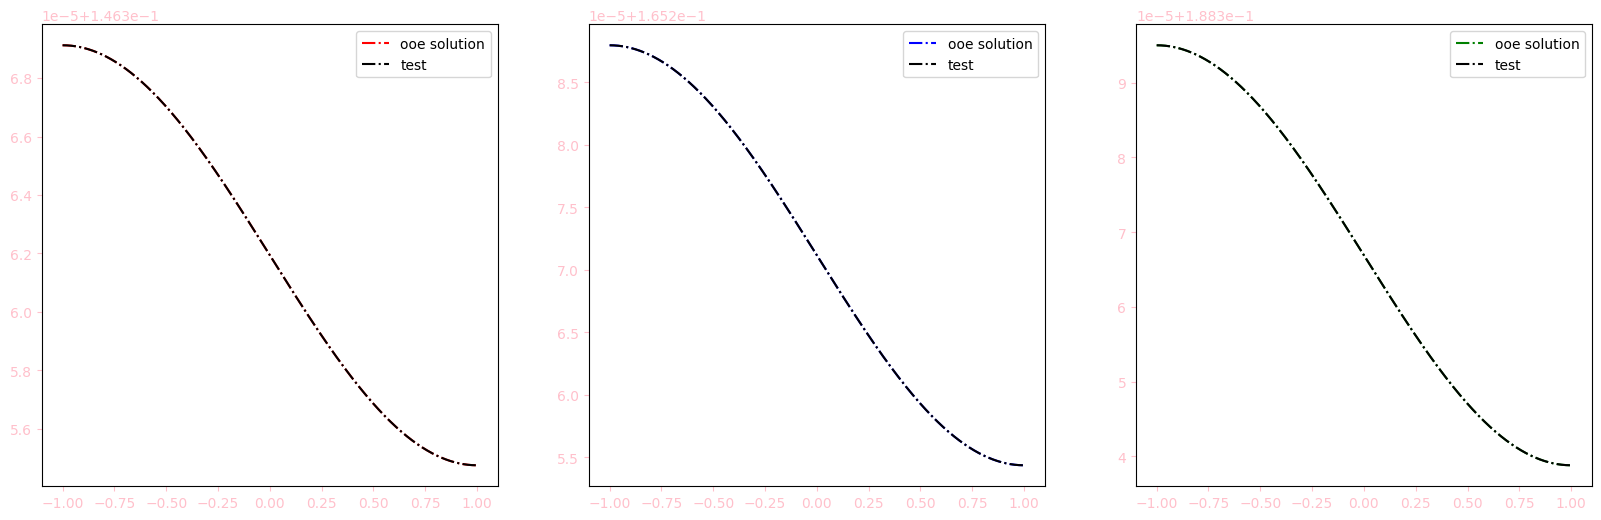

In [15]:
fig,ax = plt.subplots(ncols=3,figsize=(20,6))
ColorCycle = np.array(['red','blue', 'green', 'cyan', 'black','gray'])


ax[0].plot(X,rho_a_ooe,color = ColorCycle[0],linestyle='-.',label='ooe solution')
ax[0].plot(X,rho_a_noneq,color = ColorCycle[4],linestyle='-.',label='test')


ax[1].plot(X,rho_b_ooe,color = ColorCycle[1],linestyle='-.',label='ooe solution')
ax[1].plot(X,rho_b_noneq,color = ColorCycle[4],linestyle='-.',label='test')


ax[2].plot(X,rho_c_ooe,color = ColorCycle[2],linestyle='-.',label='ooe solution')
ax[2].plot(X,rho_c_noneq,color = ColorCycle[4],linestyle='-.',label='test')

for i in range(3):
    ax[i].tick_params(axis='x', colors='pink')
    ax[i].tick_params(axis='y', colors='pink')
    ax[i].legend()

## Looking at the divergency
Compute 
$$
\frac{\int^L_{-L} (\rho_{ana}(x,\mu)-\rho_{num}(x,\mu))^2 dx}{0.5 \int^L_{-L} (\rho_{num}(x,\mu)^2) dx}
$$

and plot as a function of mu to see the value for which the analytical expansion diverges. Renormalizing only over the numeric part as the analytical one just might be diverging. 



In [16]:
def integral(spec,Aac):
    vars_int = np.array([eta, kab0, kbc0, kac0, Eab0, Ebc0, Eac0, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, Aac, signA, signB, signC, per,  X0, Xf, n, dx])
    f_integral = physfcts(vars_int)
    rho_a_ooe,rho_b_ooe,rho_c_ooe = f_integral.NumRhos()
    rho_a_m, rho_b_m, rho_c_m = f_integral.MathRhos(X)

    if spec == "A":
      intres = np.sum((rho_a_m-rho_a_ooe)**2)*dx/(0.5*np.sum((rho_a_ooe)**2)*dx)
    elif spec == "B":
      intres = np.sum((rho_b_m-rho_b_ooe)**2)*dx/(0.5*np.sum((rho_b_ooe)**2)*dx)
    elif spec == "C":
      intres = np.sum((rho_c_m-rho_c_ooe)**2)*dx/(0.5*np.sum((rho_c_ooe)**2)*dx)
    return intres




print(integral('A',0.3),
integral('B',0.3),
integral('C',0.3))

5.8192609843764545e-11 3.8686400675041106e-10 1.989953538617862e-10


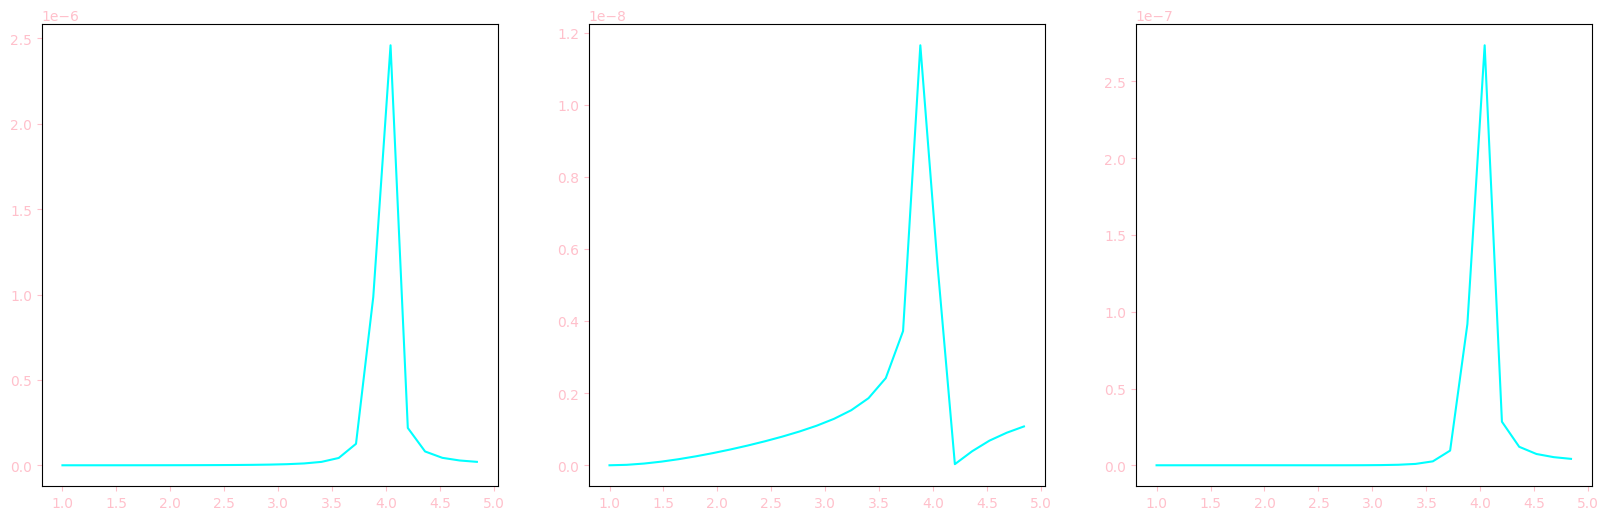

In [17]:
fig,ax = plt.subplots(ncols=3,figsize=(20,6))
nmu = 25
muvar = np.linspace(1,5,nmu,endpoint=False)

intA = np.array([integral('A',muvar[i]) for i in range(nmu)])
intB = np.array([integral('B',muvar[i]) for i in range(nmu)])
intC = np.array([integral('C',muvar[i]) for i in range(nmu)])


ax[0].plot(muvar, intA, color = ColorCycle[3])
ax[1].plot(muvar, intB, color = ColorCycle[3])
ax[2].plot(muvar, intC, color = ColorCycle[3])


for j in range(3):
    ax[j].tick_params(axis='x', colors='pink')
    ax[j].tick_params(axis='y', colors='pink')

In [18]:
def extrarho_num(spec, Aac_int):
    vars_int = np.array([eta, kab0, kbc0, kac0, Eab0, Ebc0, Eac0, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, Aac_int, signA, signB, signC, per,  X0, Xf, n, dx])
    vars_int_noeps = np.array([0, kab0, kbc0, kac0, Eab0, Ebc0, Eac0, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, Aac_int, signA, signB, signC, per,  X0, Xf, n, dx])
    f_eps = physfcts(vars_int)
    f_noeps = physfcts(vars_int_noeps)
    rho_a_ooe, rho_b_ooe, rho_c_ooe = f_eps.NumRhos()
    rho_a0, rho_b0, rho_c0 = f_noeps.NumRhos()

    if spec == "A":
      intres = np.sum((rho_a_ooe-rho_a0)**2)*dx/(0.5*np.sum((rho_a0)**2)*dx)
    elif spec == "B":
      intres = np.sum((rho_b_ooe-rho_b0)**2)*dx/(0.5*np.sum((rho_b0)**2)*dx)
    elif spec == "C":
      intres = np.sum((rho_c_ooe-rho_c0)**2)*dx/(0.5*np.sum((rho_c0)**2)*dx)
    return intres




print(extrarho_num('A', 1.),
extrarho_num('B',1.5),
extrarho_num('C',4.))

2.497171487042616e-09 1.0337078721276696e-08 2.170585133221721e-08


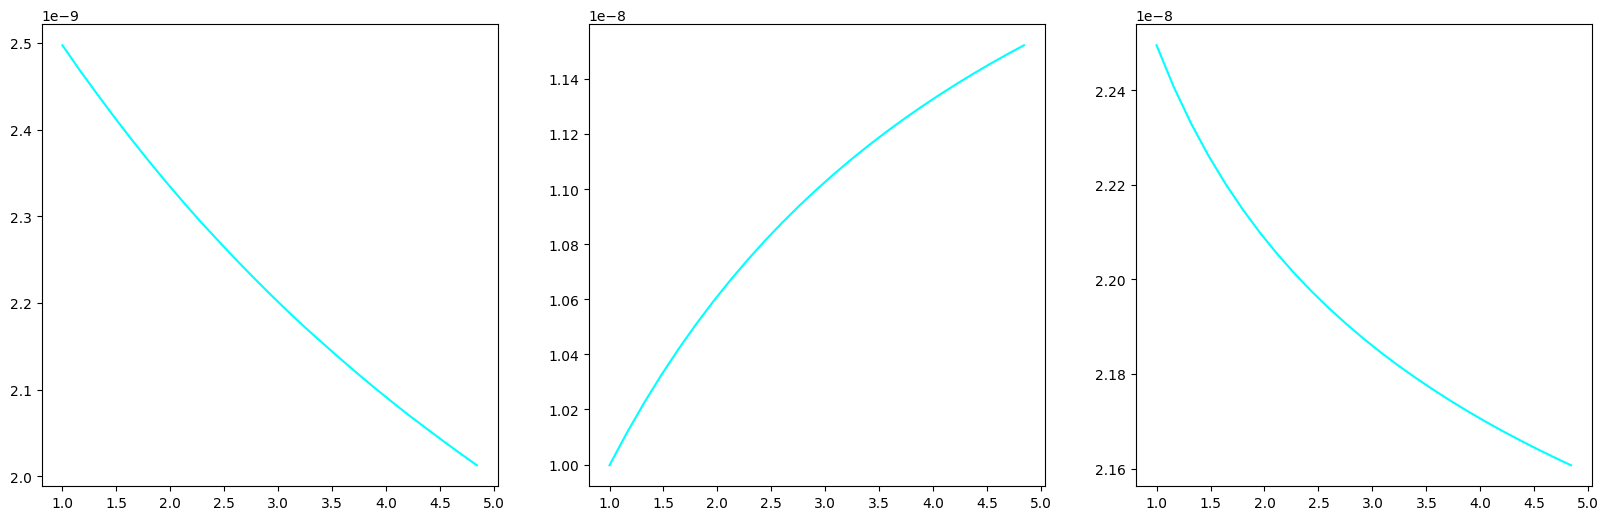

In [19]:
fig,ax = plt.subplots(ncols=3,figsize=(20,6))
nmu = 25
muvar = np.linspace(1,5,nmu,endpoint=False)

rho_surp_A = np.array([extrarho_num('A',muvar[i]) for i in range(nmu)])
rho_surp_B = np.array([extrarho_num('B',muvar[i]) for i in range(nmu)])
rho_surp_C = np.array([extrarho_num('C',muvar[i]) for i in range(nmu)])


ax[0].plot(muvar, rho_surp_A, color = ColorCycle[3])
ax[1].plot(muvar, rho_surp_B, color = ColorCycle[3])
ax[2].plot(muvar, rho_surp_C, color = ColorCycle[3])

## Plot the analytical and the numerical solution together 
incl. the numerical uncertainty of the numerical solution.

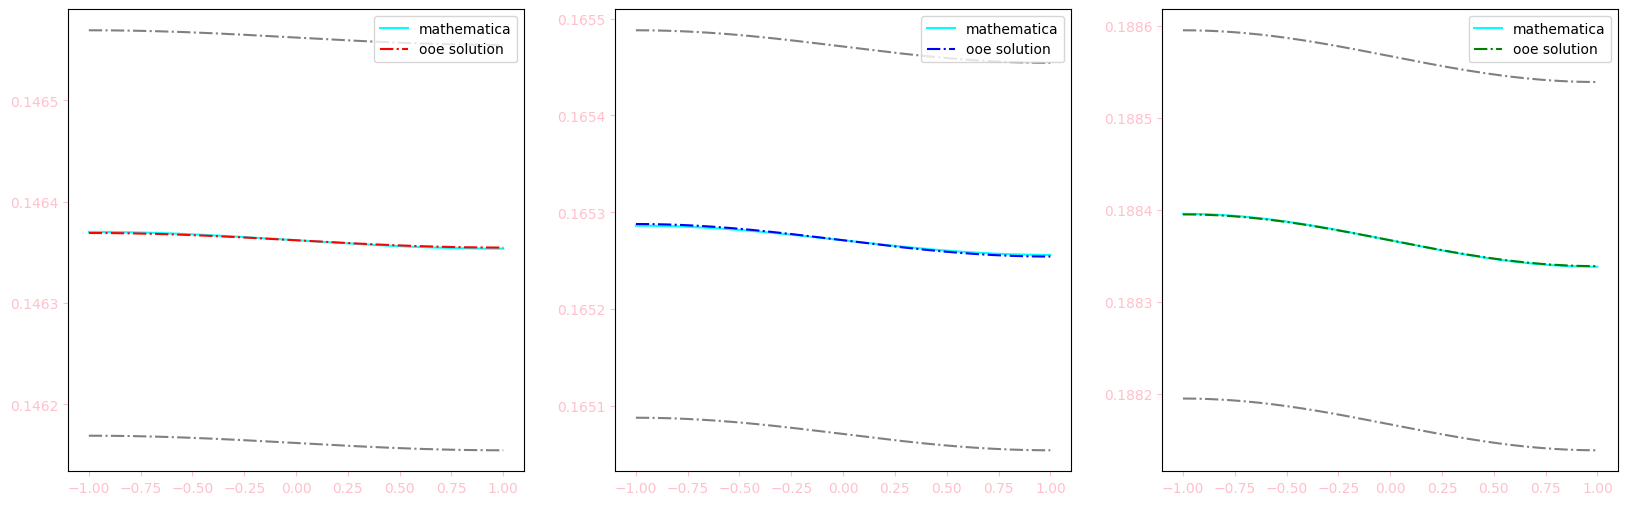

In [20]:
fig,ax = plt.subplots(ncols=3,figsize=(20,6))
ColorCycle = np.array(['red','blue', 'green', 'cyan', 'black','gray'])


ax[0].plot(X,rho_a_m,color = ColorCycle[3],label='mathematica')
ax[0].plot(X,rho_a_ooe,color = ColorCycle[0],linestyle='-.',label='ooe solution')
ax[0].plot(X,rho_a_ooe-dx,color = ColorCycle[5],linestyle='-.')
ax[0].plot(X,rho_a_ooe+dx,color = ColorCycle[5],linestyle='-.')
diff0 = np.abs(rho_a_ooe[9999]-rho_a_ooe[5000])
#ax[0].set_ylim(rho_a_ooe[5000]-np.maximum(diff0,dx)-dx,rho_a_ooe[5000]+np.maximum(diff0,dx)+dx)

ax[1].plot(X,rho_b_m,color = ColorCycle[3],label='mathematica')
ax[1].plot(X,rho_b_ooe,color = ColorCycle[1],linestyle='-.',label='ooe solution')
ax[1].plot(X,rho_b_ooe-dx,color = ColorCycle[5],linestyle='-.')
ax[1].plot(X,rho_b_ooe+dx,color = ColorCycle[5],linestyle='-.')
diff1 = np.abs(rho_b_ooe[9999]-rho_b_ooe[5000])

ax[2].plot(X,rho_c_m,color = ColorCycle[3],label='mathematica')
ax[2].plot(X,rho_c_ooe,color = ColorCycle[2],linestyle='-.',label='ooe solution')
ax[2].plot(X,rho_c_ooe-dx,color = ColorCycle[5],linestyle='-.')
ax[2].plot(X,rho_c_ooe+dx,color = ColorCycle[5],linestyle='-.')
diff2 = np.abs(rho_c_ooe[9999]-rho_c_ooe[5000])

for i in range(3):
    ax[i].tick_params(axis='x', colors='pink')
    ax[i].tick_params(axis='y', colors='pink')
    ax[i].legend()

In [21]:
def rhodiff(species, eta_in, Eab0_in, Ebc0_in, Eac0_in, Aac_in):
    vars =np.array([eta_in, kab0, kbc0, kac0, Eab0_in, Ebc0_in, Eac0_in, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, Aac_in, signA, signB, signC, per, X0, Xf, n, dx])
    fint = physfcts(vars)
    numa, numb, numc = fint.NumRhos()
    matha, mathb, mathc = fint.MathRhos(X)
    if species == 'A':
        diff = numa - matha
    elif species == 'B':
        diff = numb - mathb
    elif species == 'C':
        diff = numc - mathc    
    
    return diff



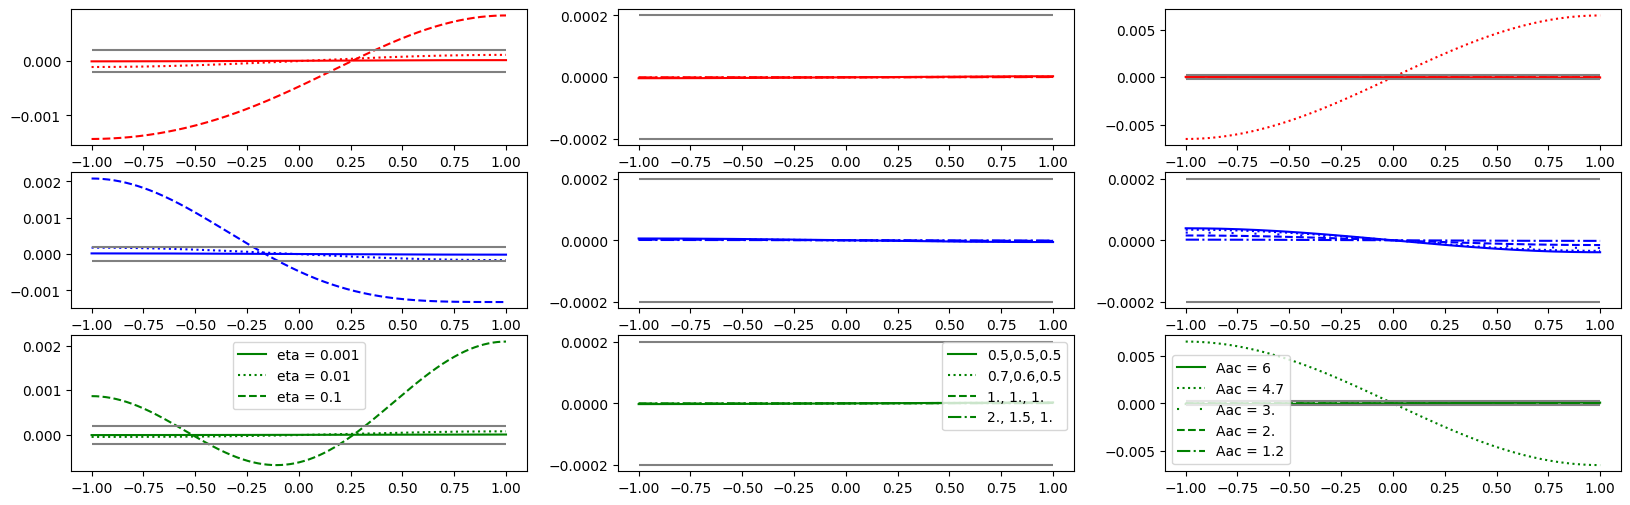

In [22]:
fig,ax = plt.subplots(ncols=3, nrows = 3,figsize=(20,6))

ax[0,0].plot(X, rhodiff('A',0.001,Eab0, Ebc0, Eac0, Aac),color = ColorCycle[0],label = 'eta = 0.001')
ax[0,0].plot(X, rhodiff('A',0.01,Eab0, Ebc0, Eac0, Aac),color = ColorCycle[0],linestyle = ':',label = 'eta = 0.01')
ax[0,0].plot(X, rhodiff('A',0.1,Eab0, Ebc0, Eac0, Aac),color = ColorCycle[0],linestyle = '--',label = 'eta = 0.1')
ax[0,0].hlines(dx, X[0],X[-1], color = 'gray')
ax[0,0].hlines(-dx, X[0],X[-1], color = 'gray')

ax[1,0].plot(X, rhodiff('B',0.001,Eab0, Ebc0, Eac0, Aac),color = ColorCycle[1],label = 'eta = 0.001')
ax[1,0].plot(X, rhodiff('B',0.01,Eab0, Ebc0, Eac0, Aac),color = ColorCycle[1],linestyle = ':',label = 'eta = 0.01')
ax[1,0].plot(X, rhodiff('B',0.1,Eab0, Ebc0, Eac0, Aac),color = ColorCycle[1],linestyle = '--',label = 'eta = 0.1')
ax[1,0].hlines(dx, X[0],X[-1], color = 'gray')
ax[1,0].hlines(-dx, X[0],X[-1], color = 'gray')

ax[2,0].plot(X, rhodiff('C',0.001,Eab0, Ebc0, Eac0, Aac),color = ColorCycle[2],label = 'eta = 0.001')
ax[2,0].plot(X, rhodiff('C',0.01,Eab0, Ebc0, Eac0, Aac),color = ColorCycle[2],linestyle = ':',label = 'eta = 0.01')
ax[2,0].plot(X, rhodiff('C',0.1,Eab0, Ebc0, Eac0, Aac),color = ColorCycle[2],linestyle = '--',label = 'eta = 0.1')
ax[2,0].hlines(dx, X[0],X[-1], color = 'gray')
ax[2,0].hlines(-dx, X[0],X[-1], color = 'gray')


ax[0,1].plot(X,rhodiff('A',0.001,0.5,0.5,0.5,1.1),color = ColorCycle[0],label='0.5,0.5,0.5')
ax[0,1].plot(X,rhodiff('A',0.001,0.7,0.6,0.5,1.1),color = ColorCycle[0],linestyle = ':',label='0.7,0.6,0.5')
ax[0,1].plot(X,rhodiff('A',0.001,1.,1.,1.,1.1),color = ColorCycle[0],linestyle = '--',label='1., 1., 1.')
ax[0,1].plot(X,rhodiff('A',0.001,2.,1.5,1.,1.1),color = ColorCycle[0],linestyle = '-.',label='2., 1.5, 1.')
ax[0,1].hlines(dx, X[0],X[-1], color = 'gray')
ax[0,1].hlines(-dx, X[0],X[-1], color = 'gray')

ax[1,1].plot(X,rhodiff('B',0.001,0.5,0.5,0.5,1.1),color = ColorCycle[1],label='0.5,0.5,0.5')
ax[1,1].plot(X,rhodiff('B',0.001,0.7,0.6,0.5,1.1),color = ColorCycle[1], linestyle = ':',label='0.7,0.6,0.5')
ax[1,1].plot(X,rhodiff('B',0.001,1.,1.,1.,1.1),color = ColorCycle[1],linestyle = '--',label='1., 1., 1.')
ax[1,1].plot(X,rhodiff('B',0.001,2.,1.5,1.,1.1),color = ColorCycle[1],linestyle = '-.',label='2., 1.5, 1.')
ax[1,1].hlines(dx, X[0],X[-1], color = 'gray')
ax[1,1].hlines(-dx, X[0],X[-1], color = 'gray')

ax[2,1].plot(X,rhodiff('C',0.001,0.5,0.5,0.5,1.1),color = ColorCycle[2],label='0.5,0.5,0.5')
ax[2,1].plot(X,rhodiff('C',0.001,0.7,0.6,0.5,1.1),color = ColorCycle[2],linestyle = ':',label='0.7,0.6,0.5')
ax[2,1].plot(X,rhodiff('C',0.001,1.,1.,1.,1.1),color = ColorCycle[2],linestyle = '--',label='1., 1., 1.')
ax[2,1].plot(X,rhodiff('C',0.001,2.,1.5,1.,1.1),color = ColorCycle[2],linestyle = '-.',label='2., 1.5, 1.')
ax[2,1].hlines(dx, X[0],X[-1], color = 'gray')
ax[2,1].hlines(-dx, X[0],X[-1], color = 'gray')

ax[0,2].plot(X,rhodiff('A',0.001, 1., 1., 1., 6.),color = ColorCycle[0],label='Aac = 6')
ax[0,2].plot(X,rhodiff('A',0.001, 1., 1., 1., 4.7),color = ColorCycle[0],linestyle = ':',label='Aac = 4.7')
ax[0,2].plot(X,rhodiff('A',0.001, 1., 1., 1., 3.),color = ColorCycle[0],linestyle = (0, (1, 10)),label='Aac = 3.')
ax[0,2].plot(X,rhodiff('A',0.001, 1., 1., 1., 2.),color = ColorCycle[0],linestyle = '--',label='Aac = 2.')
ax[0,2].plot(X,rhodiff('A',0.001, 1., 1., 1., 1.1),color = ColorCycle[0],linestyle = '-.',label='Aac = 1.2')
ax[0,2].hlines(dx, X[0],X[-1], color = 'gray')
ax[0,2].hlines(-dx, X[0],X[-1], color = 'gray')

ax[1,2].plot(X,rhodiff('B',0.001, 1., 1., 1., 6.),color = ColorCycle[1],label='Aac = 6')
ax[1,2].plot(X,rhodiff('B',0.001, 1., 1., 1., 4.7),color = ColorCycle[1],linestyle = ':',label='Aac = 4.7')
ax[1,2].plot(X,rhodiff('B',0.001, 1., 1., 1., 3.),color = ColorCycle[1],linestyle = (0, (1, 10)),label='Aac = 3.')
ax[1,2].plot(X,rhodiff('B',0.001, 1., 1., 1., 2.),color = ColorCycle[1],linestyle = '--',label='Aac = 2.')
ax[1,2].plot(X,rhodiff('B',0.001, 1., 1., 1., 1.1),color = ColorCycle[1],linestyle = '-.',label='Aac = 1.2')
ax[1,2].hlines(dx, X[0],X[-1], color = 'gray')
ax[1,2].hlines(-dx, X[0],X[-1], color = 'gray')

ax[2,2].plot(X,rhodiff('C',0.001, 1., 1., 1., 6.),color = ColorCycle[2],label='Aac = 6')
ax[2,2].plot(X,rhodiff('C',0.001, 1., 1., 1., 4.7),color = ColorCycle[2],linestyle = ':',label='Aac = 4.7')
ax[2,2].plot(X,rhodiff('C',0.001, 1., 1., 1., 3.),color = ColorCycle[2],linestyle = (0, (1, 10)),label='Aac = 3.')
ax[2,2].plot(X,rhodiff('C',0.001, 1., 1., 1., 2.),color = ColorCycle[2],linestyle = '--',label='Aac = 2.')
ax[2,2].plot(X,rhodiff('C',0.001, 1., 1., 1., 1.1),color = ColorCycle[2],linestyle = '-.',label='Aac = 1.2')
ax[2,2].hlines(dx, X[0],X[-1], color = 'gray')
ax[2,2].hlines(-dx, X[0],X[-1], color = 'gray')

for i in range(3):
    ax[2,i].legend()  

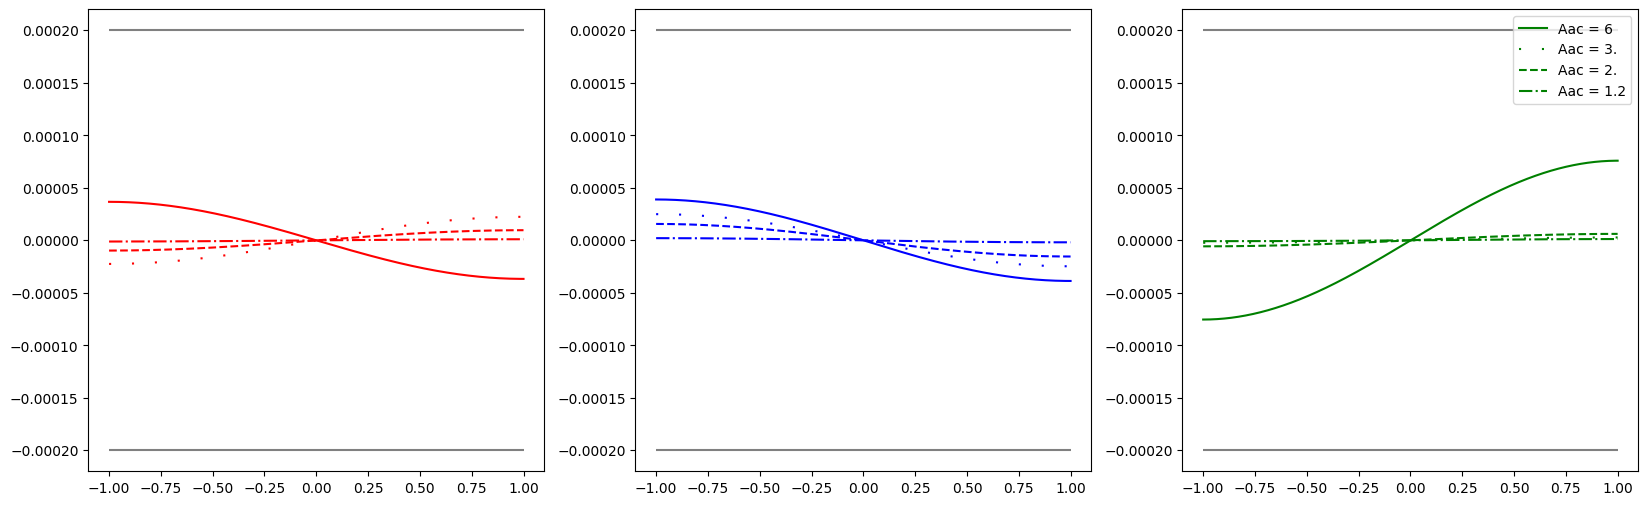

In [23]:
fig,ax = plt.subplots(ncols=3,figsize=(20,6))


ax[0].plot(X,rhodiff('A',0.001, 1., 1., 1., 6.),color = ColorCycle[0],label='Aac = 6')
#ax[0].plot(X,rhodiff('A',0.01, 1., 1., 1., 4.7),color = ColorCycle[0],linestyle = ':',label='Aac = 4.7')
ax[0].plot(X,rhodiff('A',0.001, 1., 1., 1., 3.),color = ColorCycle[0],linestyle = (0, (1, 10)),label='Aac = 3.')
ax[0].plot(X,rhodiff('A',0.001, 1., 1., 1., 2.),color = ColorCycle[0],linestyle = '--',label='Aac = 2.')
ax[0].plot(X,rhodiff('A',0.001, 1., 1., 1., 1.1),color = ColorCycle[0],linestyle = '-.',label='Aac = 1.2')
ax[0].hlines(dx, X[0],X[-1], color = 'gray')
ax[0].hlines(-dx, X[0],X[-1], color = 'gray')

ax[1].plot(X,rhodiff('B',0.001, 1., 1., 1., 6.),color = ColorCycle[1],label='Aac = 6')
#ax[1].plot(X,rhodiff('B',0.01, 1., 1., 1., 4.7),color = ColorCycle[1],linestyle = ':',label='Aac = 4.7')
ax[1].plot(X,rhodiff('B',0.001, 1., 1., 1., 3.),color = ColorCycle[1],linestyle = (0, (1, 10)),label='Aac = 3.')
ax[1].plot(X,rhodiff('B',0.001, 1., 1., 1., 2.),color = ColorCycle[1],linestyle = '--',label='Aac = 2.')
ax[1].plot(X,rhodiff('B',0.001, 1., 1., 1., 1.1),color = ColorCycle[1],linestyle = '-.',label='Aac = 1.2')
ax[1].hlines(dx, X[0],X[-1], color = 'gray')
ax[1].hlines(-dx, X[0],X[-1], color = 'gray')

ax[2].plot(X,rhodiff('C',0.001, 1., 1., 1., 6.),color = ColorCycle[2],label='Aac = 6')
#ax[2].plot(X,rhodiff('C',0.01, 1., 1., 1., 4.7),color = ColorCycle[2],linestyle = ':',label='Aac = 4.7')
ax[2].plot(X,rhodiff('C',0.001, 1., 1., 1., 3.),color = ColorCycle[2],linestyle = (0, (1, 10)),label='Aac = 3.')
ax[2].plot(X,rhodiff('C',0.001, 1., 1., 1., 2.),color = ColorCycle[2],linestyle = '--',label='Aac = 2.')
ax[2].plot(X,rhodiff('C',0.001, 1., 1., 1., 1.1),color = ColorCycle[2],linestyle = '-.',label='Aac = 1.2')
ax[2].hlines(dx, X[0],X[-1], color = 'gray')
ax[2].hlines(-dx, X[0],X[-1], color = 'gray')

for i in range(3):
    ax[2].legend()  

For eta*V > 0.01, the *equilibrium* solutions stop agreeing. As can be seen in the Mathematica code for the fluxes, the first order is not dominant for eta < 0.001. Hence, also here it is advisable to choose eta < 0.001, which results is good agreement between the two rho's. Quite satisfyingly.



## Look at the fluxes

In [24]:
A_eq_diff__diff_flux = f.diff_flux(rho_a_diff,f.Va_out(X))
#A_eq_chem__diff_flux = diff_flux(rho_a_chem,Va(X),dx)
#A_eq__diff_flux = diff_flux(rho_a_eq,f.Va_out(X),dx)
A_ooe__diff_flux = f.diff_flux(rho_a_ooe,f.Va_out(X))

B_eq_diff__diff_flux = f.diff_flux(rho_b_diff,f.Vb_out(X))
#B_eq_chem__diff_flux = diff_flux(rho_b_chem,Vb(X),dx)
#B_eq__diff_flux = diff_flux(rho_b_eq,f.Vb_out(X),dx)
B_ooe__diff_flux = f.diff_flux(rho_b_ooe,f.Vb_out(X))

C_eq_diff__diff_flux = f.diff_flux(rho_c_diff,f.Vc_out(X))
#C_eq_chem__diff_flux = diff_flux(rho_c_chem,Vc(X),dx)
#C_eq__diff_flux = diff_flux(rho_c_eq,f.Vc_out(X),dx)
C_ooe__diff_flux = f.diff_flux(rho_c_ooe,f.Vc_out(X))

## Short aside on the analytical fluxes:

In [25]:
A_flux_math, B_flux_math, C_flux_math = f.flux_ana(X)
expAB = np.exp(Eab0)
expAC = np.exp(Eac0)
expBC = np.exp(Ebc0)
pi = np.pi
C_flux_math_alt = - ((eta* pi *np.cos((pi *X)/2) *(4* (-1 + Aac) *(-expAC* expBC* (-8 + expAB* pi**2)* (V1a - V1b) + 
    4* Aac* expAB* expBC* (V1a - V1c) + 4* expAB* expAC* (-V1b + V1c)) + 
    eta *signC *V1c *(4 *(-1 + Aac)* (4* Aac* expAB *expBC* V1a - expAC* expBC* (-8 + expAB* pi**2) *(V1a - V1b) - 
    4* expAB* expAC* V1b) + (-16* (-1 + Aac)* expAB* (-expAC + Aac* expBC) - (expAC + 
    Aac* (expAB + expBC))* (-16* (expAB + 2* Aac* expAB + 3* expAC + (2 + Aac) *expBC) + 
    4* (2 *expAC *expBC + expAB *(2* expAC + expBC + Aac* expBC)) *pi**2 - 
    expAB *expAC *expBC* pi**4)* signC)* V1c)* np.sin((pi* X)/2)))/(4 *(expAB + 2 *Aac* expAB + 
    3 *expAC + (2 + Aac)* expBC) *(16* (expAB + 2* Aac* expAB + 3 *expAC + (2 + Aac)* expBC) - 
    4* (2 *expAC *expBC + expAB* (2* expAC + expBC + Aac* expBC))* pi**2 + expAB* expAC* expBC* pi**4)))

The "alternative" is taking the entire rho x dV instead of rho0 x dV. This shows that eta needs to be below 0.001 in order for this flux to not be dominated by the sine contribution from rho1. 

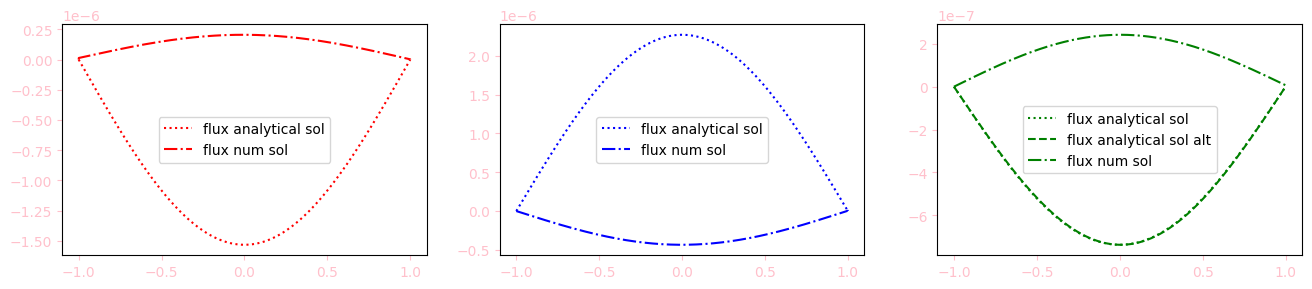

In [26]:
fig,ax = plt.subplots(ncols=3,figsize=(16,3))

#ax[0].plot(X,A_eq_diff__diff_flux,color=ColorCycle[0])
#ax[0].plot(X,A_eq_chem__diff_flux,color=ColorCycle[0],linestyle='--')
ax[0].plot(X,A_flux_math,color = ColorCycle[0],linestyle=':', label = "flux analytical sol")
ax[0].plot(X,A_ooe__diff_flux,color = ColorCycle[0],linestyle='-.',label='flux num sol')

#ax[1].plot(X,B_eq_diff__diff_flux,color=ColorCycle[1])
#ax[1].plot(X,B_eq_chem__diff_flux,color=ColorCycle[1],linestyle='--')
ax[1].plot(X,B_flux_math,color = ColorCycle[1],linestyle=':', label = "flux analytical sol")
ax[1].plot(X,B_ooe__diff_flux,color = ColorCycle[1],linestyle='-.',label='flux num sol')

#ax[2].plot(X,C_eq_diff__diff_flux,color=ColorCycle[2])
#ax[2].plot(X,C_eq_chem__diff_flux,color=ColorCycle[2],linestyle='--')
ax[2].plot(X,C_flux_math,color = ColorCycle[2],linestyle=':', label = "flux analytical sol")
ax[2].plot(X,C_flux_math_alt,color = ColorCycle[2],linestyle='--', label = "flux analytical sol alt")
ax[2].plot(X,C_ooe__diff_flux,color = ColorCycle[2],linestyle='-.',label='flux num sol')

for i in range(3):
    ax[i].tick_params(axis='x', colors='pink')
    ax[i].tick_params(axis='y', colors='pink')
    ax[i].legend()

The fluxes disagree. Here is why:
rho*dV gives:

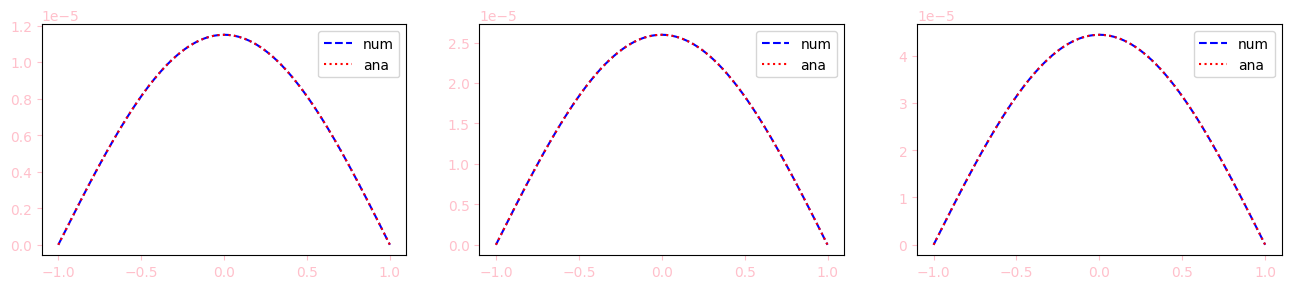

In [27]:
fig,ax = plt.subplots(ncols=3,figsize=(16,3))

ax[0].plot(X,rho_a_ooe*D(f.Va_out(X),dx),color = ColorCycle[1],linestyle='--', label = "num")
ax[0].plot(X,rho_a_m*(pi* signA *V1a*eta*np.cos((pi*X)/(2)))/(2),color = ColorCycle[0],linestyle=':',label='ana')

ax[1].plot(X,rho_b_ooe*D(f.Vb_out(X),dx),color = ColorCycle[1],linestyle='--', label = "num")
ax[1].plot(X,rho_b_m*(pi* signB *V1b*eta*np.cos((pi*X)/(2)))/(2),color = ColorCycle[0],linestyle=':',label='ana')

ax[2].plot(X,rho_c_ooe*D(f.Vc_out(X),dx),color = ColorCycle[1],linestyle='--', label = "num")
ax[2].plot(X,rho_c_m*(pi* signB *V1c*eta*np.cos((pi*X)/(2)))/(2),color = ColorCycle[0],linestyle=':', label = "ana")

for i in range(3):
    ax[i].tick_params(axis='x', colors='pink')
    ax[i].tick_params(axis='y', colors='pink')
    ax[i].legend()

drho gives:

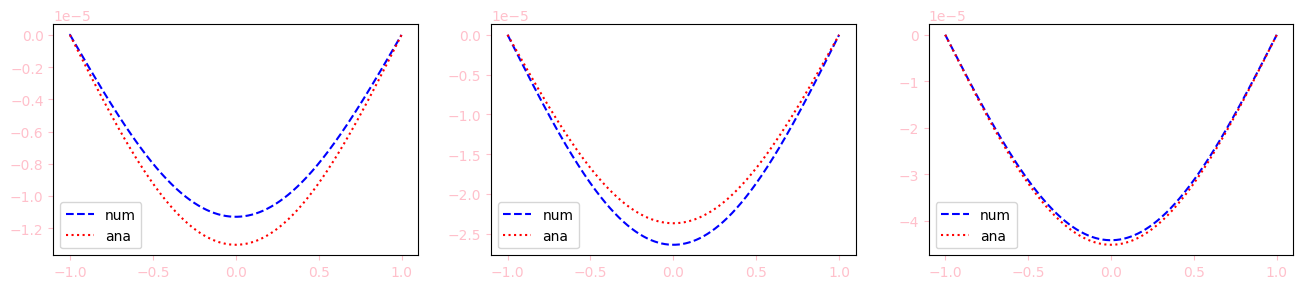

In [28]:
fig,ax = plt.subplots(ncols=3,figsize=(16,3))

X = np.linspace(X0,Xf,n,endpoint=False)

testA = (eta* pi *(-16 *(-1 + Aac)* expAC *expBC *V1a + 
     expAB**2* (16 + 32* Aac - 4* (2* expAC + expBC + Aac* expBC) *pi**2 + 
        expAC* expBC* pi**4) *signA *V1a - 
     8 *(expAC + expBC)* (-2* (2 + Aac) *expBC + 
        expAC* (-6 + expBC* pi**2))* signA* V1a + 
     16* (-1 + Aac) *expAC* expBC* V1b + 
     expAB* (8 *expAC* (8 + 4 *Aac - expAC* pi**2) *signA* V1a + 
        expBC**2* pi**2* (-4 - 4* Aac + expAC* pi**2)* signA* V1a + 
        expBC* (-16 + (48 + expAC* pi**2* (-20 + expAC* pi**2))* signA + 
           Aac* (16 + 48* signA - 4* expAC *pi**2* signA))* V1a + 
        32 *(-1 + Aac)* expAC* (V1b - V1c) - 
        4 *(-1 + Aac)* expBC* (expAC* pi**2* (V1b - V1c) + 4* V1c)))* np.cos((
    pi* X)/2))/(4* (expAB + 2 *Aac* expAB + 
     3 *expAC + (2 + Aac)* expBC)* (-16* (expAB + 2* Aac* expAB + 
        3* expAC + (2 + Aac)* expBC) + 
     4 *(2* expAC *expBC + expAB* (2 *expAC + expBC + Aac* expBC)) *pi**2 - 
     expAB* expAC* expBC* pi**4))

testB = (eta* pi *(-16 *(-1 + Aac) *expAC* expBC* V1a + 
     16* (-1 + Aac)* expAC* expBC* V1b + 
     Aac* expAB**2* (16 + 32* Aac - 4* (2 *expAC + expBC + Aac* expBC) *pi**2 +
         expAC* expBC* pi**4)* signB *V1b - 
     8* (expAC + expBC)* (-2* (2 + Aac) *expBC + 
        expAC *(-6 + expBC *pi**2))* signB* V1b + 
     expAB* (expBC**2* pi**2* (-4 - 4* Aac + expAC* pi**2) *signB *V1b + 
        8 *expAC* ((2 - 2* Aac + 2* signB + 10* Aac* signB - 
              expAC *pi**2* signB)* V1b + 2 *(-1 + Aac) *V1c) + 
        expBC* (-4* (-1 + Aac)* (4 + 4* Aac - expAC* pi**2)* V1a + (16 + 
              16* Aac* (4 + Aac) - 12 *(1 + Aac)* expAC* pi**2 + 
              expAC**2* pi**4)* signB* V1b + 
           4* (-1 + Aac)* (4 + 4* Aac - expAC* pi**2)* V1c)))* np.cos((pi* X)/
    2))/(4* (expAB + 2 *Aac* expAB + 
     3 *expAC + (2 + Aac)* expBC)* (-16 *(expAB + 2 *Aac* expAB + 
        3* expAC + (2 + Aac)* expBC) + 
     4* (2* expAC* expBC + expAB* (2* expAC + expBC + Aac* expBC))* pi**2 - 
     expAB* expAC* expBC* pi**4))
   
testC = (eta* pi *(4 *(-1 + Aac)* (4* Aac* expAB* expBC *V1a - 
        expAC* expBC* (-8 + expAB *pi**2)* (V1a - V1b) - 
        4* expAB* expAC* V1b) + (-16* (-1 + Aac)* expAB* (-expAC + 
           Aac *expBC) - (expAC + 
           Aac* (expAB + expBC))* (-16* (expAB + 2* Aac *expAB + 
              3* expAC + (2 + Aac) *expBC) + 
           4* (2* expAC* expBC + 
              expAB* (2* expAC + expBC + Aac* expBC)) *pi**2 - 
           expAB* expAC* expBC* pi**4)* signC) *V1c)* np.cos((pi *X)/
    2))/(4* (expAB + 2 *Aac* expAB + 
     3 *expAC + (2 + Aac)* expBC)* (-16 *(expAB + 2* Aac* expAB + 
        3* expAC + (2 + Aac)* expBC) + 
     4 *(2* expAC* expBC + expAB* (2* expAC + expBC + Aac* expBC))* pi**2 - 
     expAB* expAC* expBC* pi**4))

ax[0].plot(X,D(rho_a_ooe,dx),color = ColorCycle[1],linestyle='--', label = "num")
ax[0].plot(X,testA,color = ColorCycle[0],linestyle=':',label='ana')

ax[1].plot(X,D(rho_b_ooe,dx),color = ColorCycle[1],linestyle='--', label = "num")
ax[1].plot(X,testB,color = ColorCycle[0],linestyle=':',label='ana')

ax[2].plot(X,D(rho_c_ooe,dx),color = ColorCycle[1],linestyle='--', label = "num")
ax[2].plot(X,testC,color = ColorCycle[0],linestyle=':', label = "ana")

for i in range(3):
    ax[i].tick_params(axis='x', colors='pink')
    ax[i].tick_params(axis='y', colors='pink')
    ax[i].legend()

The two are about the same size of opposite sign. And this is why the final fluxes look like they’re all over the place. I vote they’re just too small. I conclude that the analytic solution is technically correct, but plotting it makes it look wrong just because we need a higher steepness to get higher fluxes, which we cannot get with the sine.

In [29]:
np.sum(A_ooe__diff_flux+B_ooe__diff_flux+C_ooe__diff_flux)*dx

2.5691057078491046e-08

## Different aside on sensitivity of the singularity:

In [30]:
def flux_sum_mu(mu):
    res = np.ones_like(mu)
    for i in range(len(mu)):
        varsint = np.array([eta, kab0, kbc0, kac0, Eab0, Ebc0, Eac0, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, mu[i], signA, signB, signC, per, X0, Xf, n, dx])
        fint = physfcts(varsint)
        rhoA, rhoB, rhoC = fint.NumRhos()
        fluxA = fint.diff_flux(rhoA,fint.Va_out(X))
        fluxB = fint.diff_flux(rhoB,fint.Va_out(X))
        fluxC = fint.diff_flux(rhoC,fint.Va_out(X))
        res[i] = np.sum(fluxA**2 + fluxB**2 + fluxC**2)*dx
    return res

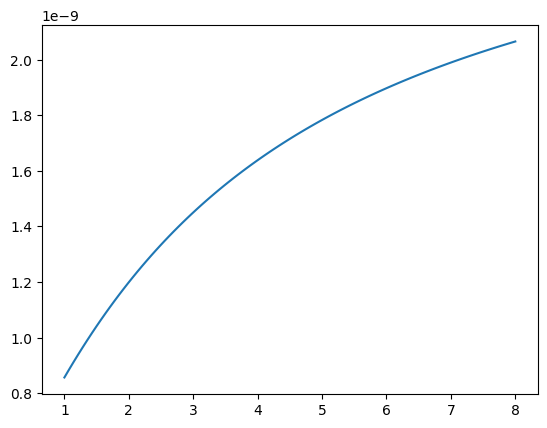

In [31]:
mu_ar = np.linspace(1,8,100)
plt.plot(mu_ar, flux_sum_mu(mu_ar))

## Back to plotting sensible fluxes:

Compute chemical fluxes. Remember that we conveniently got rid of the units from the top, so now the fluxes are all unitless and can be compared directly.

In [32]:
array2 = np.array([0., kab0, kbc0, kac0, Eab0, Ebc0, Eac0, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, Aac, signA, signB, signC, per, X0, Xf, n, dx])
f2 = physfcts(array2)
delta_chem_flux = f2.flux_cc(X)-f2.flux_cw(X)

In [33]:
#test: for no activity, no delta
array3 = np.array([0., kab0, kbc0, kac0, Eab0, Ebc0, Eac0, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, 1., signA, signB, signC, per, X0, Xf, n, dx])
f3 = physfcts(array3)
print(f3.flux_cc(X))
print(f3.flux_cw(X))

[0.2451659 0.2451659 0.2451659 ... 0.2451659 0.2451659 0.2451659]
[0.2451659 0.2451659 0.2451659 ... 0.2451659 0.2451659 0.2451659]


Nice.

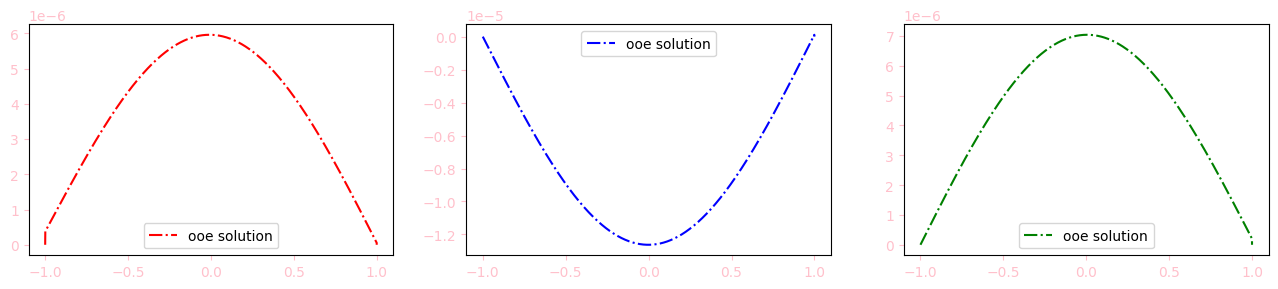

In [34]:
fig,ax = plt.subplots(ncols=3,figsize=(16,3))

X = np.linspace(X0,Xf,n,endpoint=False)

ax[0].plot(X,A_ooe__diff_flux/delta_chem_flux,color = ColorCycle[0],linestyle='-.',label='ooe solution')
ax[1].plot(X,B_ooe__diff_flux/delta_chem_flux,color = ColorCycle[1],linestyle='-.',label='ooe solution')
ax[2].plot(X,C_ooe__diff_flux/delta_chem_flux,color = ColorCycle[2],linestyle='-.',label='ooe solution')

for i in range(3):
    ax[i].tick_params(axis='x', colors='pink')
    ax[i].tick_params(axis='y', colors='pink')
    ax[i].legend()

In [35]:
delta_chem_flux

array([0.03440704, 0.03440704, 0.03440704, ..., 0.03440704, 0.03440704,
       0.03440704])

In [36]:
chemA, chemB, chemC = f.chem_flux(X)
print(chemA)

[-3.01059262e-07 -3.01062227e-07 -3.01065161e-07 ...  3.17481752e-07
  3.17482430e-07  3.17483078e-07]


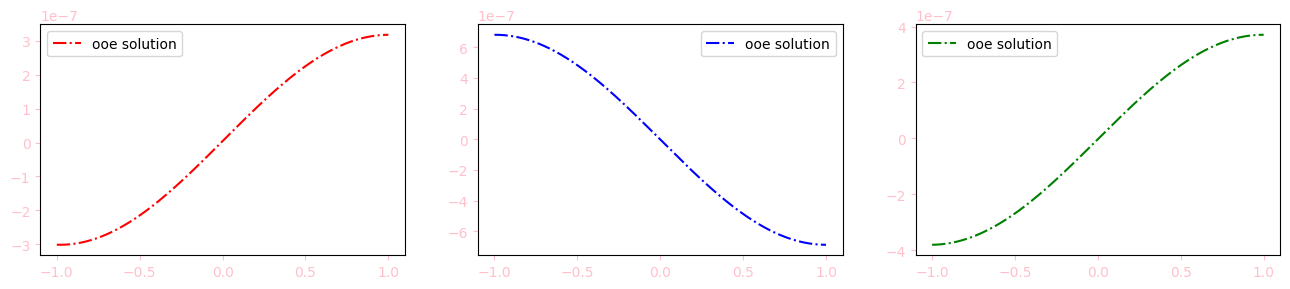

In [37]:
fig,ax = plt.subplots(ncols=3,figsize=(16,3))

ax[0].plot(X,chemA,color = ColorCycle[0],linestyle='-.',label='ooe solution')
ax[1].plot(X,chemB,color = ColorCycle[1],linestyle='-.',label='ooe solution')
ax[2].plot(X,chemC,color = ColorCycle[2],linestyle='-.',label='ooe solution')

for i in range(3):
    ax[i].tick_params(axis='x', colors='pink')
    ax[i].tick_params(axis='y', colors='pink')
    ax[i].legend()

In [38]:
print(np.sum(chemA)*dx, np.sum(chemB)*dx, np.sum(chemC)*dx)

1.1008532214634715e-08 -4.055495103710838e-09 -6.953037111437355e-09


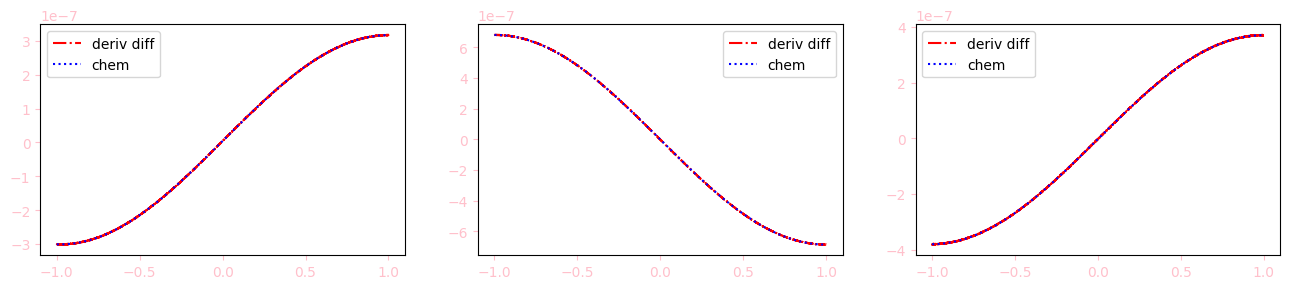

In [39]:
fig,ax = plt.subplots(ncols=3,figsize=(16,3))

ax[0].plot(X[2:-2], -D(A_ooe__diff_flux,dx)[2:-2],color = ColorCycle[0],linestyle='-.',label='deriv diff')
ax[1].plot(X[2:-2], -D(B_ooe__diff_flux,dx)[2:-2],color = ColorCycle[0],linestyle='-.',label='deriv diff')
ax[2].plot(X[2:-2], -D(C_ooe__diff_flux,dx)[2:-2],color = ColorCycle[0],linestyle='-.',label='deriv diff')
ax[0].plot(X[2:-2], chemA[2:-2],color = ColorCycle[1],linestyle=':',label='chem')
ax[1].plot(X[2:-2], chemB[2:-2],color = ColorCycle[1],linestyle=':',label='chem')
ax[2].plot(X[2:-2], chemC[2:-2],color = ColorCycle[1],linestyle=':',label='chem')

for i in range(3):
    ax[i].tick_params(axis='x', colors='pink')
    ax[i].tick_params(axis='y', colors='pink')
    ax[i].legend()

Good.

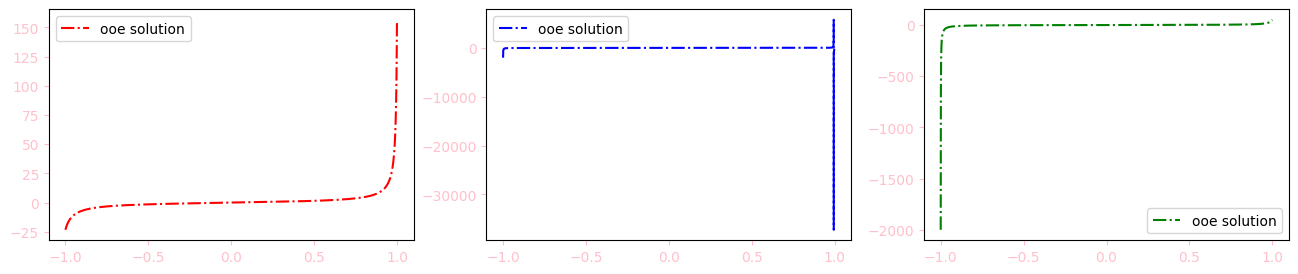

In [40]:
fig,ax = plt.subplots(ncols=3,figsize=(16,3))

ax[0].plot(X[2:-3],chemA[2:-3]/A_ooe__diff_flux[2:-3],color = ColorCycle[0],linestyle='-.',label='ooe solution')
ax[1].plot(X[2:-3],chemB[2:-3]/B_ooe__diff_flux[2:-3],color = ColorCycle[1],linestyle='-.',label='ooe solution')
ax[2].plot(X[2:-3],chemC[2:-3]/C_ooe__diff_flux[2:-3],color = ColorCycle[2],linestyle='-.',label='ooe solution')

for i in range(3):
    ax[i].tick_params(axis='x', colors='pink')
    ax[i].tick_params(axis='y', colors='pink')
    ax[i].legend()

Definite wtf.

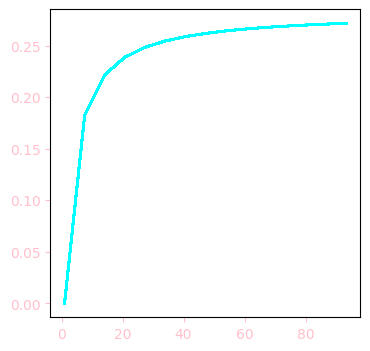

In [41]:
fig,ax = plt.subplots(ncols=1,figsize=(4,4))
nmu = 15
Aacvar = np.linspace(1,100,nmu,endpoint=False)
def delta_as_fct_A(Aacvar):
    array_int = np.array([0., kab0, kbc0, kac0, Eab0, Ebc0, Eac0, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, Aacvar, signA, signB, signC, per, X0, Xf, n, dx])
    f2 = physfcts(array_int)
    return f2.flux_cc(X)-f2.flux_cw(X)


argument = np.array([delta_as_fct_A(Aacvar[i]) for i in range(nmu)])

ax.plot(Aacvar, argument, color = ColorCycle[3])

ax.tick_params(axis='x', colors='pink')
ax.tick_params(axis='y', colors='pink')




Can I take Aac arbitrarily high?

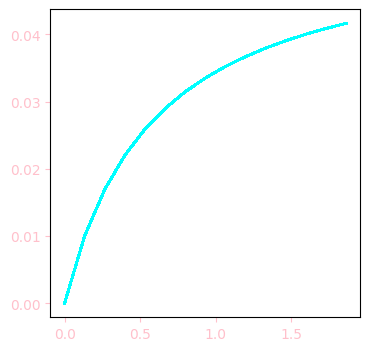

In [42]:
fig,ax = plt.subplots(ncols=1,figsize=(4,4))
nmu = 15
kacvar = np.linspace(0,2,nmu,endpoint=False)
def delta_as_fct_k(kac0var):
    array_int = np.array([0., kab0, kbc0, kac0var, Eab0, Ebc0, Eac0, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, Aac, signA, signB, signC, per, X0, Xf, n, dx])
    f2 = physfcts(array_int)
    return f2.flux_cc(X)-f2.flux_cw(X)


argument = np.array([delta_as_fct_k(kacvar[i]) for i in range(nmu)])

ax.plot(kacvar, argument, color = ColorCycle[3])

ax.tick_params(axis='x', colors='pink')
ax.tick_params(axis='y', colors='pink')

## Look at how the fluxes change with the periodicity of the sine (and the steepness)

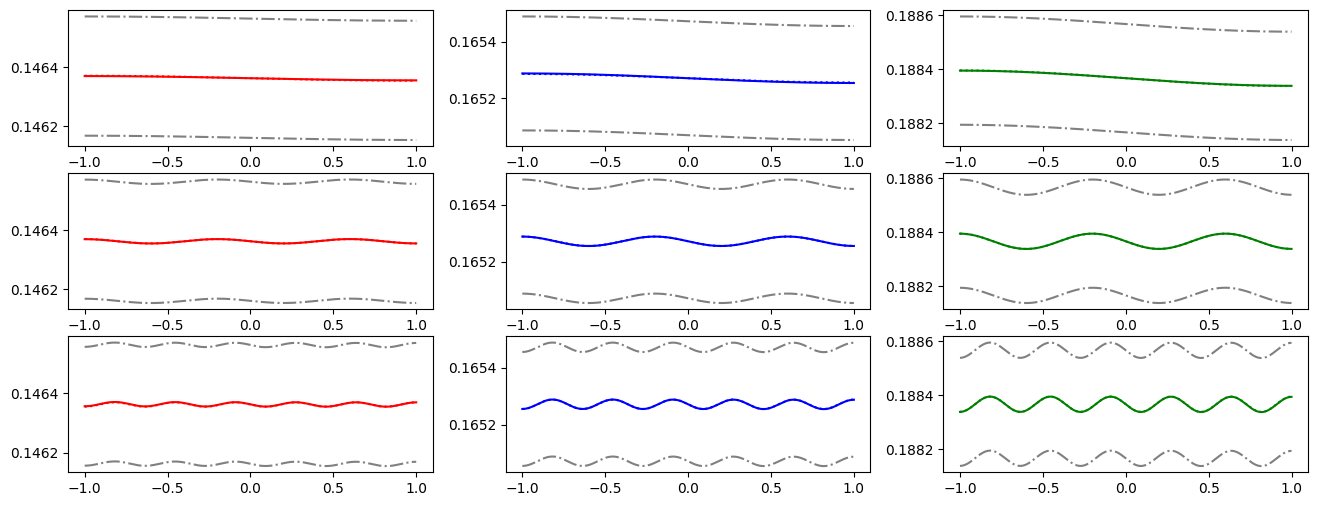

In [84]:
fig,ax = plt.subplots(ncols=3, nrows = 3,figsize=(16,6))

def rho_fct_per(per_var):
    var_int = np.array([eta, kab0, kbc0, kac0, Eab0, Ebc0, Eac0, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, Aac, signA, signB, signC, per_var, X0, Xf, n, dx])
    fint = physfcts(var_int)
    A_ooe, B_ooe, C_ooe = fint.NumRhos()
    A_m_ooe, B_m_ooe, C_m_ooe = fint.MathRhos(X)
    return A_ooe, B_ooe, C_ooe, A_m_ooe, B_m_ooe, C_m_ooe

ax[0,0].plot(X,rho_fct_per(1.)[0],color = ColorCycle[0],linestyle='-',label='A, 1.')
ax[0,1].plot(X,rho_fct_per(1.)[1],color = ColorCycle[1],linestyle='-',label='B, 1.')
ax[0,2].plot(X,rho_fct_per(1.)[2],color = ColorCycle[2],linestyle='-',label='C, 1.')
ax[0,0].plot(X,rho_fct_per(1.)[3],color = ColorCycle[0],linestyle=':',label='A, 1.')
ax[0,1].plot(X,rho_fct_per(1.)[4],color = ColorCycle[1],linestyle=':',label='B, 1.')
ax[0,2].plot(X,rho_fct_per(1.)[5],color = ColorCycle[2],linestyle=':',label='C, 1.')
ax[0,0].plot(X,rho_fct_per(1.)[0]-dx,color = ColorCycle[5],linestyle='-.')
ax[0,0].plot(X,rho_fct_per(1.)[0]+dx,color = ColorCycle[5],linestyle='-.')
ax[0,1].plot(X,rho_fct_per(1.)[1]-dx,color = ColorCycle[5],linestyle='-.')
ax[0,1].plot(X,rho_fct_per(1.)[1]+dx,color = ColorCycle[5],linestyle='-.')
ax[0,2].plot(X,rho_fct_per(1.)[2]-dx,color = ColorCycle[5],linestyle='-.')
ax[0,2].plot(X,rho_fct_per(1.)[2]+dx,color = ColorCycle[5],linestyle='-.')

ax[1,0].plot(X,rho_fct_per(5.)[0],color = ColorCycle[0],linestyle='-',label='A, 5.')
ax[1,1].plot(X,rho_fct_per(5.)[1],color = ColorCycle[1],linestyle='-',label='B, 5.')
ax[1,2].plot(X,rho_fct_per(5.)[2],color = ColorCycle[2],linestyle='-',label='C, 5.')
ax[1,0].plot(X,rho_fct_per(5.)[3],color = ColorCycle[0],linestyle=':',label='A, 5.')
ax[1,1].plot(X,rho_fct_per(5.)[4],color = ColorCycle[1],linestyle=':',label='B, 5.')
ax[1,2].plot(X,rho_fct_per(5.)[5],color = ColorCycle[2],linestyle=':',label='C, 5.')
ax[1,0].plot(X,rho_fct_per(5.)[0]-dx,color = ColorCycle[5],linestyle='-.')
ax[1,0].plot(X,rho_fct_per(5.)[0]+dx,color = ColorCycle[5],linestyle='-.')
ax[1,1].plot(X,rho_fct_per(5.)[1]-dx,color = ColorCycle[5],linestyle='-.')
ax[1,1].plot(X,rho_fct_per(5.)[1]+dx,color = ColorCycle[5],linestyle='-.')
ax[1,2].plot(X,rho_fct_per(5.)[2]-dx,color = ColorCycle[5],linestyle='-.')
ax[1,2].plot(X,rho_fct_per(5.)[2]+dx,color = ColorCycle[5],linestyle='-.')

ax[2,0].plot(X,rho_fct_per(11.)[0],color = ColorCycle[0],linestyle='-',label='A, 11.')
ax[2,1].plot(X,rho_fct_per(11.)[1],color = ColorCycle[1],linestyle='-',label='B, 11.')
ax[2,2].plot(X,rho_fct_per(11.)[2],color = ColorCycle[2],linestyle='-',label='C, 11.')
ax[2,0].plot(X,rho_fct_per(11.)[3],color = ColorCycle[0],linestyle=':',label='A, 11.')
ax[2,1].plot(X,rho_fct_per(11.)[4],color = ColorCycle[1],linestyle=':',label='B, 11.')
ax[2,2].plot(X,rho_fct_per(11.)[5],color = ColorCycle[2],linestyle=':',label='C, 11.')
ax[2,0].plot(X,rho_fct_per(11.)[0]-dx,color = ColorCycle[5],linestyle='-.')
ax[2,0].plot(X,rho_fct_per(11.)[0]+dx,color = ColorCycle[5],linestyle='-.')
ax[2,1].plot(X,rho_fct_per(11.)[1]-dx,color = ColorCycle[5],linestyle='-.')
ax[2,1].plot(X,rho_fct_per(11.)[1]+dx,color = ColorCycle[5],linestyle='-.')
ax[2,2].plot(X,rho_fct_per(11.)[2]-dx,color = ColorCycle[5],linestyle='-.')
ax[2,2].plot(X,rho_fct_per(11.)[2]+dx,color = ColorCycle[5],linestyle='-.')


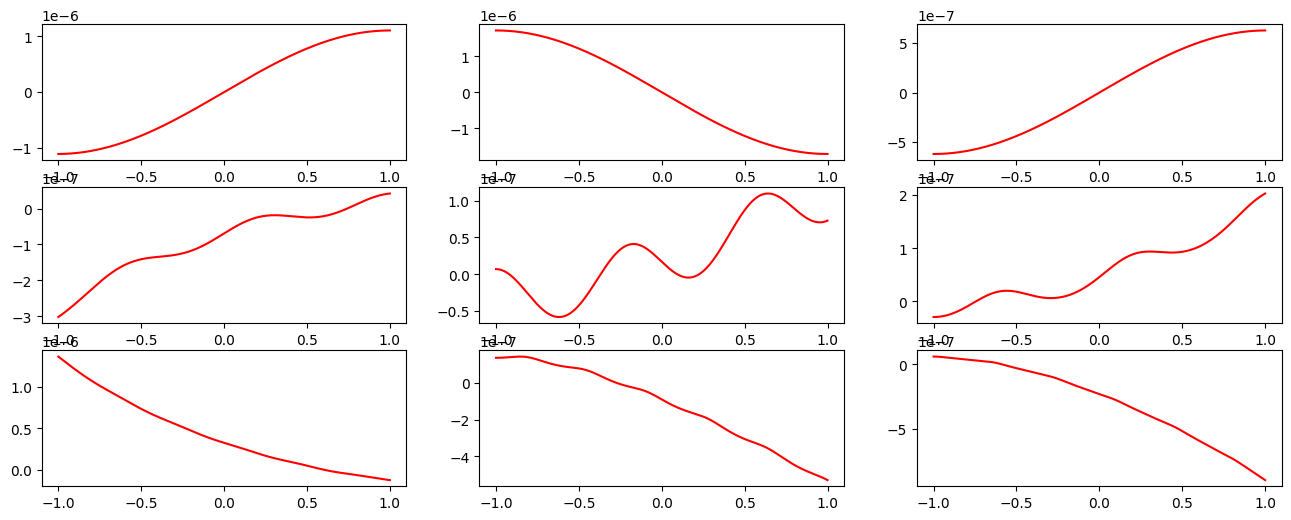

In [96]:
fig,ax = plt.subplots(ncols=3, nrows = 3,figsize=(16,6))

def diff_rho_fct_per(per_var):
    var_int = np.array([eta, kab0, kbc0, kac0, Eab0, Ebc0, Eac0, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, Aac, signA, signB, signC, per_var, X0, Xf, n, dx])
    fint = physfcts(var_int)
    A_ooe, B_ooe, C_ooe = fint.NumRhos()
    A_m_ooe, B_m_ooe, C_m_ooe = fint.MathRhos(X)
    return A_ooe, B_ooe, C_ooe, A_m_ooe, B_m_ooe, C_m_ooe

ax[0,0].plot(X,diff_rho_fct_per(1.)[0]-diff_rho_fct_per(1.)[3],color = ColorCycle[0],linestyle='-',label='A, 1.')
ax[0,1].plot(X,diff_rho_fct_per(1.)[1]-diff_rho_fct_per(1.)[4],color = ColorCycle[0],linestyle='-',label='B, 1.')
ax[0,2].plot(X,diff_rho_fct_per(1.)[2]-diff_rho_fct_per(1.)[5],color = ColorCycle[0],linestyle='-',label='C, 1.')

ax[1,0].plot(X,diff_rho_fct_per(5.)[0]-diff_rho_fct_per(5.)[3],color = ColorCycle[0],linestyle='-',label='A, 5.')
ax[1,1].plot(X,diff_rho_fct_per(5.)[1]-diff_rho_fct_per(5.)[4],color = ColorCycle[0],linestyle='-',label='B, 5.')
ax[1,2].plot(X,diff_rho_fct_per(5.)[2]-diff_rho_fct_per(5.)[5],color = ColorCycle[0],linestyle='-',label='C, 5.')

ax[2,0].plot(X,diff_rho_fct_per(11.)[0]-diff_rho_fct_per(11.)[3],color = ColorCycle[0],linestyle='-',label='A, 11.')
ax[2,1].plot(X,diff_rho_fct_per(11.)[1]-diff_rho_fct_per(11.)[4],color = ColorCycle[0],linestyle='-',label='B, 11.')
ax[2,2].plot(X,diff_rho_fct_per(11.)[2]-diff_rho_fct_per(11.)[5],color = ColorCycle[0],linestyle='-',label='C, 11.')

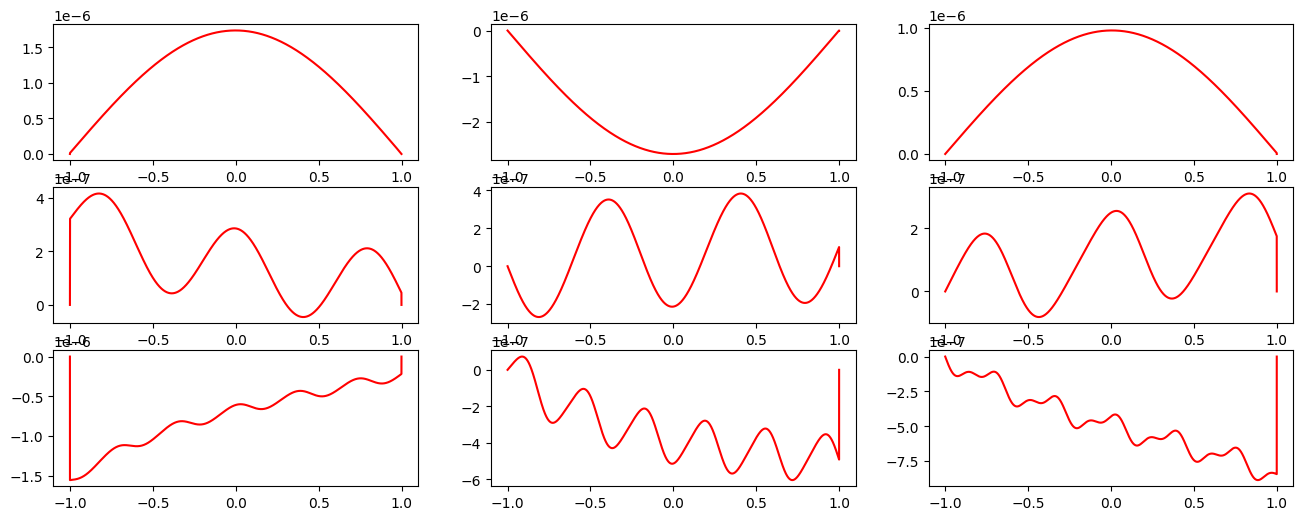

In [94]:
fig,ax = plt.subplots(ncols=3, nrows = 3,figsize=(16,6))

def drho_fct_per(per_var):
    var_int = np.array([eta, kab0, kbc0, kac0, Eab0, Ebc0, Eac0, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, Aac, signA, signB, signC, per_var, X0, Xf, n, dx])
    fint = physfcts(var_int)
    A_ooe, B_ooe, C_ooe = fint.NumRhos()
    A_m_ooe, B_m_ooe, C_m_ooe = fint.MathRhos(X)
    return D(A_ooe,dx), D(B_ooe,dx), D(C_ooe,dx), D(A_m_ooe,dx) , D(B_m_ooe,dx), D(C_m_ooe,dx)

ax[0,0].plot(X,drho_fct_per(1.)[0]-drho_fct_per(1.)[3],color = ColorCycle[0],linestyle='-',label='A, 1.')
ax[0,1].plot(X,drho_fct_per(1.)[1]-drho_fct_per(1.)[4],color = ColorCycle[0],linestyle='-',label='B, 1.')
ax[0,2].plot(X,drho_fct_per(1.)[2]-drho_fct_per(1.)[5],color = ColorCycle[0],linestyle='-',label='C, 1.')

ax[1,0].plot(X,drho_fct_per(5.)[0]-drho_fct_per(5.)[3],color = ColorCycle[0],linestyle='-',label='A, 5.')
ax[1,1].plot(X,drho_fct_per(5.)[1]-drho_fct_per(5.)[4],color = ColorCycle[0],linestyle='-',label='B, 5.')
ax[1,2].plot(X,drho_fct_per(5.)[2]-drho_fct_per(5.)[5],color = ColorCycle[0],linestyle='-',label='C, 5.')

ax[2,0].plot(X,drho_fct_per(11.)[0]-drho_fct_per(11.)[3],color = ColorCycle[0],linestyle='-',label='A, 11.')
ax[2,1].plot(X,drho_fct_per(11.)[1]-drho_fct_per(11.)[4],color = ColorCycle[0],linestyle='-',label='B, 11.')
ax[2,2].plot(X,drho_fct_per(11.)[2]-drho_fct_per(11.)[5],color = ColorCycle[0],linestyle='-',label='C, 11.')

In [69]:
print(drho_fct_per(5.)[0][-1],drho_fct_per(5.)[1][-1],drho_fct_per(5.)[2][-1],drho_fct_per(5.)[3][-1],
drho_fct_per(5.)[4][-1],drho_fct_per(5.)[5][-1])

0.0 0.0 0.0 0.0 0.0 0.0


In [73]:
np.cos(np.arccos(0))

6.123233995736766e-17

In [70]:
print(dV_fct_per(5.)[0][-1],dV_fct_per(5.)[1][-1],dV_fct_per(5.)[2][-1],
dV_fct_per(5.)[3][-1],dV_fct_per(5.)[4][-1],dV_fct_per(5.)[5][-1])

0.0 0.0 0.0 0.009027884820946788 0.020387465878367754 0.03485300852955881


In [71]:
print(drho_fct_per(11.)[0][-1],drho_fct_per(11.)[1][-1],drho_fct_per(11.)[2][-1],drho_fct_per(11.)[3][-1],
drho_fct_per(11.)[4][-1],drho_fct_per(11.)[5][-1])

0.0 0.0 0.0 0.0 0.0 0.0


In [72]:
print(dV_fct_per(11.)[0][-1],dV_fct_per(11.)[1][-1],dV_fct_per(11.)[2][-1],
dV_fct_per(11.)[3][-1],dV_fct_per(11.)[4][-1],dV_fct_per(11.)[5][-1])

0.0 0.0 0.0 -0.04369926667135142 -0.09869490225108085 -0.16873891903611105


In [74]:
X

array([-1.    , -0.9998, -0.9996, ...,  0.9994,  0.9996,  0.9998])

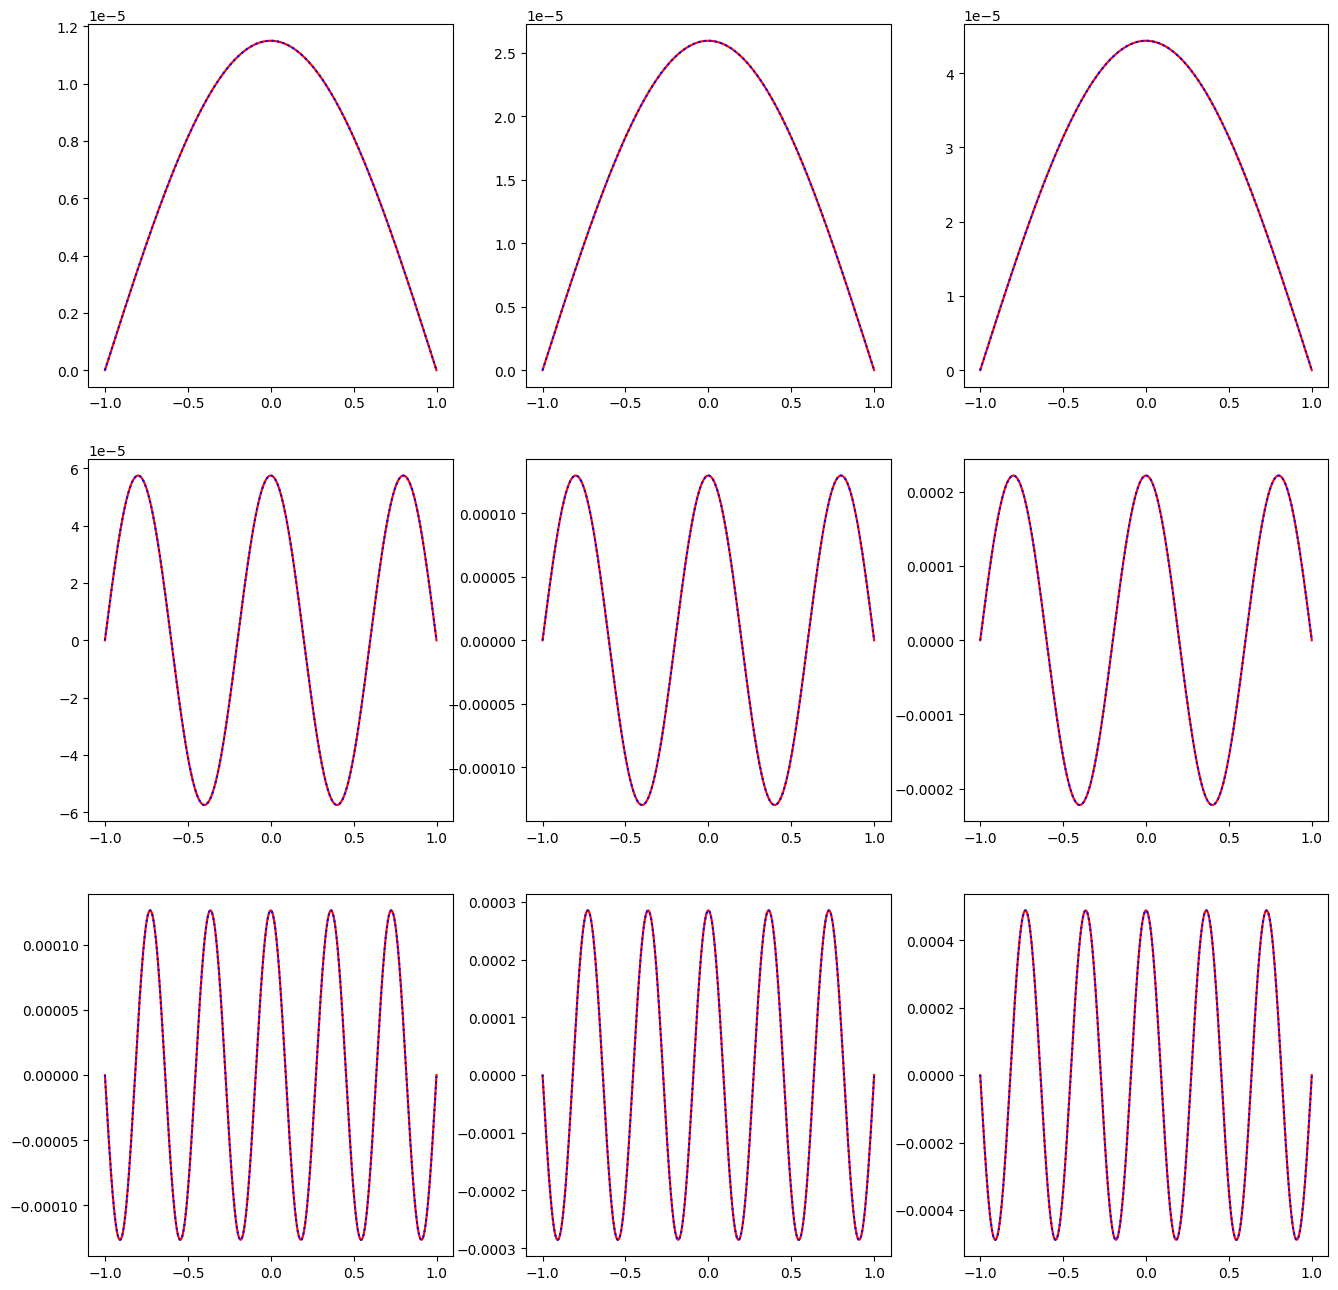

In [89]:
fig,ax = plt.subplots(ncols=3, nrows = 3,figsize=(16,16))

def dV_fct_per(per_var):
    var_int = np.array([eta, kab0, kbc0, kac0, Eab0, Ebc0, Eac0, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, Aac, signA, signB, signC, per_var, X0, Xf, n, dx])
    fint = physfcts(var_int)
    A_ooe, B_ooe, C_ooe = fint.NumRhos()
    A_m_ooe, B_m_ooe, C_m_ooe = fint.MathRhos(X)
    dVa = D(fint.Va_out(X),dx)
    dVb = D(fint.Vb_out(X),dx)
    dVc = D(fint.Vc_out(X),dx)
    dVa_m = np.pi*per_var* signA *V1a*eta*np.cos(per_var*np.pi*X/2)/2
    dVb_m = np.pi*per_var* signB *V1b*eta*np.cos(per_var*np.pi*X/2)/2
    dVc_m = np.pi*per_var* signC *V1c*eta*np.cos(per_var*np.pi*X/2)/2
    return A_ooe*dVa, B_ooe*dVb, C_ooe*dVc, A_m_ooe*dVa_m, B_m_ooe*dVb_m, C_m_ooe*dVc_m

ax[0,0].plot(X,dV_fct_per(1.)[0],color = ColorCycle[0],linestyle='-',label='A, 1.')
ax[0,1].plot(X,dV_fct_per(1.)[1],color = ColorCycle[0],linestyle='-',label='B, 1.')
ax[0,2].plot(X,dV_fct_per(1.)[2],color = ColorCycle[0],linestyle='-',label='C, 1.')
ax[0,0].plot(X,dV_fct_per(1.)[3],color = ColorCycle[1],linestyle=':',label='A, 1.')
ax[0,1].plot(X,dV_fct_per(1.)[4],color = ColorCycle[1],linestyle=':',label='B, 1.')
ax[0,2].plot(X,dV_fct_per(1.)[5],color = ColorCycle[1],linestyle=':',label='C, 1.')


ax[1,0].plot(X,dV_fct_per(5.)[0],color = ColorCycle[0],linestyle='-',label='A, 5.')
ax[1,1].plot(X,dV_fct_per(5.)[1],color = ColorCycle[0],linestyle='-',label='B, 5.')
ax[1,2].plot(X,dV_fct_per(5.)[2],color = ColorCycle[0],linestyle='-',label='C, 5.')
ax[1,0].plot(X,dV_fct_per(5.)[3],color = ColorCycle[1],linestyle=':',label='A, 5.')
ax[1,1].plot(X,dV_fct_per(5.)[4],color = ColorCycle[1],linestyle=':',label='B, 5.')
ax[1,2].plot(X,dV_fct_per(5.)[5],color = ColorCycle[1],linestyle=':',label='C, 5.')


ax[2,0].plot(X,dV_fct_per(11.)[0],color = ColorCycle[0],linestyle='-',label='A, 11.')
ax[2,1].plot(X,dV_fct_per(11.)[1],color = ColorCycle[0],linestyle='-',label='B, 11.')
ax[2,2].plot(X,dV_fct_per(11.)[2],color = ColorCycle[0],linestyle='-',label='C, 11.')
ax[2,0].plot(X,dV_fct_per(11.)[3],color = ColorCycle[1],linestyle=':',label='A, 11.')
ax[2,1].plot(X,dV_fct_per(11.)[4],color = ColorCycle[1],linestyle=':',label='B, 11.')
ax[2,2].plot(X,dV_fct_per(11.)[5],color = ColorCycle[1],linestyle=':',label='C, 11.')

In [63]:
print(drho_fct_per(5.)[0][-1]+dV_fct_per(5.)[0][-1],
drho_fct_per(5.)[1][-1]+dV_fct_per(5.)[1][-1],
drho_fct_per(5.)[2][-1]+dV_fct_per(5.)[2][-1],
drho_fct_per(5.)[3][-1]+dV_fct_per(5.)[3][-1],
drho_fct_per(5.)[4][-1]+dV_fct_per(5.)[4][-1],
drho_fct_per(5.)[5][-1]+dV_fct_per(5.)[5][-1])

0.0 0.0 0.0 0.009027884820946788 0.020387465878367754 0.03485300852955881


In [65]:
print(drho_fct_per(5.)[0][-2]+dV_fct_per(5.)[0][-2],
drho_fct_per(5.)[1][-2]+dV_fct_per(5.)[1][-2],
drho_fct_per(5.)[2][-2]+dV_fct_per(5.)[2][-2],
drho_fct_per(5.)[3][-2]+dV_fct_per(5.)[3][-2],
drho_fct_per(5.)[4][-2]+dV_fct_per(5.)[4][-2],
drho_fct_per(5.)[5][-2]+dV_fct_per(5.)[5][-2])

0.004533797669970436 0.010159781928488529 0.017440695129915765 -2.4602347568267874e-05 4.308852925267309e-05 -3.388004672323641e-05


In [64]:
def fluxexpl_fct_per(per_var):
    drho1, drho2, drho3, drho4, drho5, drho6 = drho_fct_per(per_var)
    dv1, dv2, dv3, dv4, dv5, dv6 = dV_fct_per(per_var)
    return drho1+dv1, drho2+dv2, drho3+dv3, drho4+dv4, drho5+dv5, drho6+dv6

In [66]:
fluxexpl_fct_per(5.)

(array([0.        , 0.03214046, 0.03214549, ..., 0.00454704, 0.0045338 ,
        0.        ]),
 array([ 0.00000000e+00, -2.91613952e-05, -4.85962180e-05, ...,
         1.01371460e-02,  1.01597819e-02,  0.00000000e+00]),
 array([0.00000000e+00, 2.16882251e-05, 3.61710830e-05, ...,
        1.74501324e-02, 1.74406951e-02, 0.00000000e+00]),
 array([ 1.75978924e-15, -1.13964282e-05, -2.27943207e-05, ...,
        -3.69002209e-05, -2.46023476e-05,  9.02788482e-03]),
 array([3.97448779e-15, 2.56148349e-05, 5.12348518e-05, ...,
        6.46250328e-05, 4.30885293e-05, 2.03874659e-02]),
 array([ 6.79519254e-15, -6.47770404e-06, -1.29512633e-05, ...,
        -5.07990415e-05, -3.38800467e-05,  3.48530085e-02]))

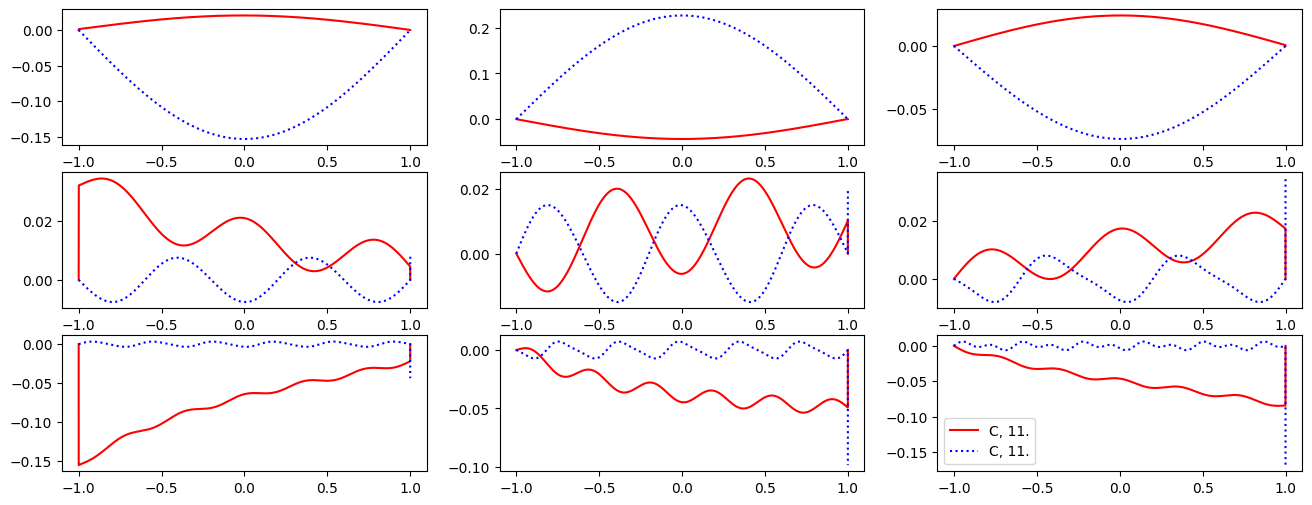

In [68]:
fig,ax = plt.subplots(ncols=3, nrows = 3,figsize=(16,6))


ax[0,0].plot(X,fluxexpl_fct_per(1.)[0],color = ColorCycle[0],linestyle='-',label='A, 1.')
ax[0,1].plot(X,fluxexpl_fct_per(1.)[1],color = ColorCycle[0],linestyle='-',label='B, 1.')
ax[0,2].plot(X,fluxexpl_fct_per(1.)[2],color = ColorCycle[0],linestyle='-',label='C, 1.')
ax[0,0].plot(X,fluxexpl_fct_per(1.)[3],color = ColorCycle[1],linestyle=':',label='A, 1.')
ax[0,1].plot(X,fluxexpl_fct_per(1.)[4],color = ColorCycle[1],linestyle=':',label='B, 1.')
ax[0,2].plot(X,fluxexpl_fct_per(1.)[5],color = ColorCycle[1],linestyle=':',label='C, 1.')


ax[1,0].plot(X,fluxexpl_fct_per(5.)[0],color = ColorCycle[0],linestyle='-',label='A, 5.')
"""ax[1,0].set_xlabel()
ax[1,0].set_ylabel()
ax[1,0].title()
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])"""

ax[1,1].plot(X,fluxexpl_fct_per(5.)[1],color = ColorCycle[0],linestyle='-',label='B, 5.')
ax[1,2].plot(X,fluxexpl_fct_per(5.)[2],color = ColorCycle[0],linestyle='-',label='C, 5.')
ax[1,0].plot(X,fluxexpl_fct_per(5.)[3],color = ColorCycle[1],linestyle=':',label='A, 5.')
ax[1,1].plot(X,fluxexpl_fct_per(5.)[4],color = ColorCycle[1],linestyle=':',label='B, 5.')
ax[1,2].plot(X,fluxexpl_fct_per(5.)[5],color = ColorCycle[1],linestyle=':',label='C, 5.')


ax[2,0].plot(X,fluxexpl_fct_per(11.)[0],color = ColorCycle[0],linestyle='-',label='A, 11.')
ax[2,1].plot(X,fluxexpl_fct_per(11.)[1],color = ColorCycle[0],linestyle='-',label='B, 11.')
ax[2,2].plot(X,fluxexpl_fct_per(11.)[2],color = ColorCycle[0],linestyle='-',label='C, 11.')
ax[2,0].plot(X,fluxexpl_fct_per(11.)[3],color = ColorCycle[1],linestyle=':',label='A, 11.')
ax[2,1].plot(X,fluxexpl_fct_per(11.)[4],color = ColorCycle[1],linestyle=':',label='B, 11.')
ax[2,2].plot(X,fluxexpl_fct_per(11.)[5],color = ColorCycle[1],linestyle=':',label='C, 11.')

plt.legend()

In [80]:
fluxexpl_fct_per(5.)[0]

array([0.        , 0.03214046, 0.03214549, ..., 0.00454704, 0.0045338 ,
       0.        ])

KeyboardInterrupt: 

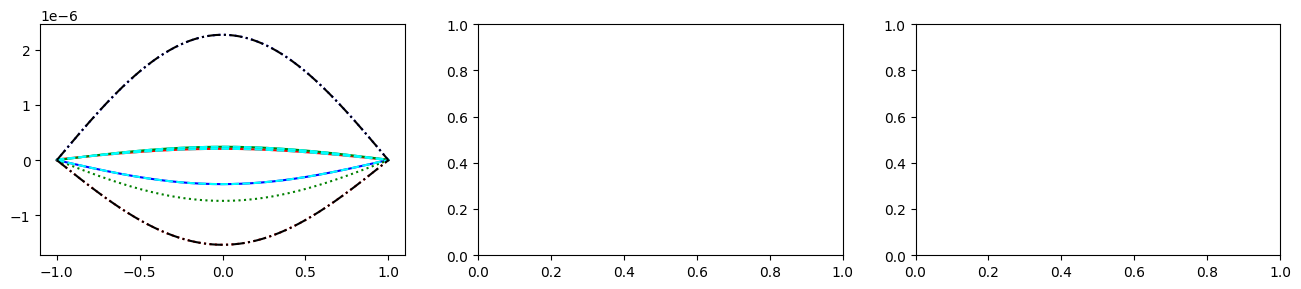

In [48]:
fig,ax = plt.subplots(ncols=3,figsize=(16,3))

def flux_fct_per(per_var):
    var_int = np.array([eta, kab0, kbc0, kac0, Eab0, Ebc0, Eac0, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, Aac, signA, signB, signC, per_var, X0, Xf, n, dx])
    fint = physfcts(var_int)
    A_ooe = fint.diff_flux(rho_a_ooe,fint.Va_out(X))
    B_ooe = fint.diff_flux(rho_b_ooe,fint.Vb_out(X))
    C_ooe = fint.diff_flux(rho_c_ooe,fint.Vc_out(X))
    A_m_ooe, B_m_ooe, C_m_ooe = fint.flux_ana(X)
    return A_ooe, B_ooe, C_ooe, A_m_ooe, B_m_ooe, C_m_ooe

ax[0].plot(X,flux_fct_per(1.)[0],color = ColorCycle[0],linestyle='-',label='A, 1.')
ax[0].plot(X,flux_fct_per(1.)[1],color = ColorCycle[1],linestyle='-',label='B, 1.')
ax[0].plot(X,flux_fct_per(1.)[2],color = ColorCycle[2],linestyle='-',label='C, 1.')
ax[0].plot(X,flux_fct_per(1.)[3],color = ColorCycle[0],linestyle=':',label='A, 1.')
ax[0].plot(X,flux_fct_per(1.)[4],color = ColorCycle[1],linestyle=':',label='B, 1.')
ax[0].plot(X,flux_fct_per(1.)[5],color = ColorCycle[2],linestyle=':',label='C, 1.')
ax[0].plot(X,fluxexpl_fct_per(1.)[0],color = ColorCycle[3],linestyle='--',label='A, 1.')
ax[0].plot(X,fluxexpl_fct_per(1.)[1],color = ColorCycle[3],linestyle='--',label='B, 1.')
ax[0].plot(X,fluxexpl_fct_per(1.)[2],color = ColorCycle[3],linestyle='--',label='C, 1.')
ax[0].plot(X,fluxexpl_fct_per(1.)[3],color = ColorCycle[4],linestyle='-.',label='A, 1.')
ax[0].plot(X,fluxexpl_fct_per(1.)[4],color = ColorCycle[4],linestyle='-.',label='B, 1.')
ax[0].plot(X,fluxexpl_fct_per(1.)[5],color = ColorCycle[4],linestyle='-.',label='C, 1.')


ax[1].plot(X,flux_fct_per(5.)[0],color = ColorCycle[0],linestyle='-',label='A, 5.')
ax[1].plot(X,flux_fct_per(5.)[1],color = ColorCycle[1],linestyle='-',label='B, 5.')
ax[1].plot(X,flux_fct_per(5.)[2],color = ColorCycle[2],linestyle='-',label='C, 5.')
ax[1].plot(X,flux_fct_per(5.)[3],color = ColorCycle[0],linestyle=':',label='A, 5.')
ax[1].plot(X,flux_fct_per(5.)[4],color = ColorCycle[1],linestyle=':',label='B, 5.')
ax[1].plot(X,flux_fct_per(5.)[5],color = ColorCycle[2],linestyle=':',label='C, 5.')
ax[1].plot(X,fluxexpl_fct_per(5.)[0],color = ColorCycle[3],linestyle='--',label='A, 5.')
ax[1].plot(X,fluxexpl_fct_per(5.)[1],color = ColorCycle[3],linestyle='--',label='B, 5.')
ax[1].plot(X,fluxexpl_fct_per(5.)[2],color = ColorCycle[3],linestyle='--',label='C, 5.')
ax[1].plot(X,fluxexpl_fct_per(5.)[3],color = ColorCycle[4],linestyle='-.',label='A, 5.')
ax[1].plot(X,fluxexpl_fct_per(5.)[4],color = ColorCycle[4],linestyle='-.',label='B, 5.')
ax[1].plot(X,fluxexpl_fct_per(5.)[5],color = ColorCycle[4],linestyle='-.',label='C, 5.')

ax[2].plot(X,flux_fct_per(11.)[0],color = ColorCycle[0],linestyle='-',label='A, 11.')
ax[2].plot(X,flux_fct_per(11.)[1],color = ColorCycle[1],linestyle='-',label='B, 11.')
ax[2].plot(X,flux_fct_per(11.)[2],color = ColorCycle[2],linestyle='-',label='C, 11.')
ax[2].plot(X,flux_fct_per(11.)[3],color = ColorCycle[0],linestyle=':',label='A, 11.')
ax[2].plot(X,flux_fct_per(11.)[4],color = ColorCycle[1],linestyle=':',label='B, 11.')
ax[2].plot(X,flux_fct_per(11.)[5],color = ColorCycle[2],linestyle=':',label='C, 11.')
ax[2].plot(X,fluxexpl_fct_per(11.)[0],color = ColorCycle[3],linestyle='--',label='A, 11.')
ax[2].plot(X,fluxexpl_fct_per(11.)[1],color = ColorCycle[3],linestyle='--',label='B, 11.')
ax[2].plot(X,fluxexpl_fct_per(11.)[2],color = ColorCycle[3],linestyle='--',label='C, 11.')
ax[2].plot(X,fluxexpl_fct_per(11.)[3],color = ColorCycle[4],linestyle='-.',label='A, 11.')
ax[2].plot(X,fluxexpl_fct_per(11.)[4],color = ColorCycle[4],linestyle='-.',label='B, 11.')
ax[2].plot(X,fluxexpl_fct_per(11.)[5],color = ColorCycle[4],linestyle='-.',label='C, 11.')

ax[2].plot(X,np.sum(flux_fct_per(11.), axis = 0),color = ColorCycle[2],linestyle='-',label='C, 11.')

for i in range(3):
    ax[i].tick_params(axis='x', colors='pink')
    ax[i].tick_params(axis='y', colors='pink')
    #ax[i].legend()



Magic cazzi.
Why does it get less asymmetric when I go further away from the divergency? (Cf. 0.5,1.,1.5 and mu 1.1 vs mu 2.)


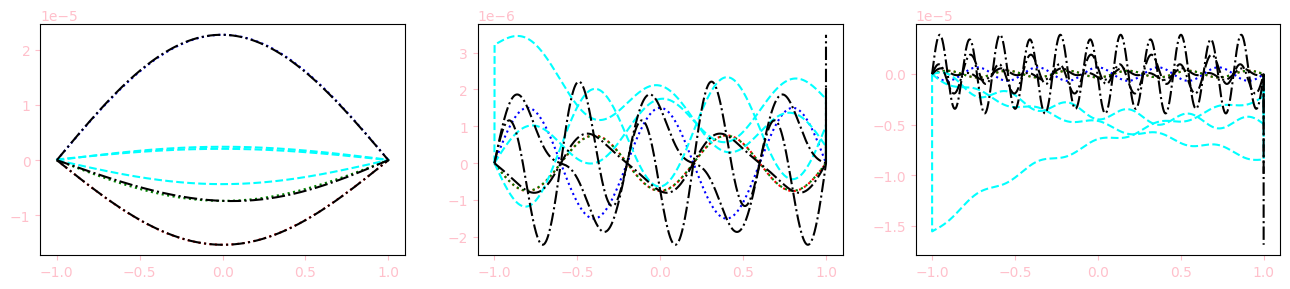

In [ ]:
fig,ax = plt.subplots(ncols=3,figsize=(16,3))


ax[0].plot(X,flux_fct_per(1.)[3],color = ColorCycle[0],linestyle=':',label='A, 1.')
ax[0].plot(X,flux_fct_per(1.)[4],color = ColorCycle[1],linestyle=':',label='B, 1.')
ax[0].plot(X,flux_fct_per(1.)[5],color = ColorCycle[2],linestyle=':',label='C, 1.')
ax[0].plot(X,fluxexpl_fct_per(1.)[0],color = ColorCycle[3],linestyle='--',label='A, 1.')
ax[0].plot(X,fluxexpl_fct_per(1.)[1],color = ColorCycle[3],linestyle='--',label='B, 1.')
ax[0].plot(X,fluxexpl_fct_per(1.)[2],color = ColorCycle[3],linestyle='--',label='C, 1.')
ax[0].plot(X,fluxexpl_fct_per(1.)[3],color = ColorCycle[4],linestyle='-.',label='A, 1.')
ax[0].plot(X,fluxexpl_fct_per(1.)[4],color = ColorCycle[4],linestyle='-.',label='B, 1.')
ax[0].plot(X,fluxexpl_fct_per(1.)[5],color = ColorCycle[4],linestyle='-.',label='C, 1.')


ax[1].plot(X,flux_fct_per(5.)[3],color = ColorCycle[0],linestyle=':',label='A, 5.')
ax[1].plot(X,flux_fct_per(5.)[4],color = ColorCycle[1],linestyle=':',label='B, 5.')
ax[1].plot(X,flux_fct_per(5.)[5],color = ColorCycle[2],linestyle=':',label='C, 5.')
ax[1].plot(X,fluxexpl_fct_per(5.)[0],color = ColorCycle[3],linestyle='--',label='A, 5.')
ax[1].plot(X,fluxexpl_fct_per(5.)[1],color = ColorCycle[3],linestyle='--',label='B, 5.')
ax[1].plot(X,fluxexpl_fct_per(5.)[2],color = ColorCycle[3],linestyle='--',label='C, 5.')
ax[1].plot(X,fluxexpl_fct_per(5.)[3],color = ColorCycle[4],linestyle='-.',label='A, 5.')
ax[1].plot(X,fluxexpl_fct_per(5.)[4],color = ColorCycle[4],linestyle='-.',label='B, 5.')
ax[1].plot(X,fluxexpl_fct_per(5.)[5],color = ColorCycle[4],linestyle='-.',label='C, 5.')


ax[2].plot(X,flux_fct_per(11.)[3],color = ColorCycle[0],linestyle=':',label='A, 11.')
ax[2].plot(X,flux_fct_per(11.)[4],color = ColorCycle[1],linestyle=':',label='B, 11.')
ax[2].plot(X,flux_fct_per(11.)[5],color = ColorCycle[2],linestyle=':',label='C, 11.')
ax[2].plot(X,fluxexpl_fct_per(11.)[0],color = ColorCycle[3],linestyle='--',label='A, 11.')
ax[2].plot(X,fluxexpl_fct_per(11.)[1],color = ColorCycle[3],linestyle='--',label='B, 11.')
ax[2].plot(X,fluxexpl_fct_per(11.)[2],color = ColorCycle[3],linestyle='--',label='C, 11.')
ax[2].plot(X,fluxexpl_fct_per(11.)[3],color = ColorCycle[4],linestyle='-.',label='A, 11.')
ax[2].plot(X,fluxexpl_fct_per(11.)[4],color = ColorCycle[4],linestyle='-.',label='B, 11.')
ax[2].plot(X,fluxexpl_fct_per(11.)[5],color = ColorCycle[4],linestyle='-.',label='C, 11.')


for i in range(3):
    ax[i].tick_params(axis='x', colors='pink')
    ax[i].tick_params(axis='y', colors='pink')
    #ax[i].legend()



In [ ]:
print(np.sum(flux_fct_per(1.)[0]+flux_fct_per(1.)[1]+flux_fct_per(1.)[2])*dx)
print(np.sum(flux_fct_per(2.)[0]+flux_fct_per(2.)[1]+flux_fct_per(2.)[2])*dx)
print(np.sum(flux_fct_per(5.)[0]+flux_fct_per(5.)[1]+flux_fct_per(5.)[2])*dx)
print(np.sum(flux_fct_per(11.)[0]+flux_fct_per(11.)[1]+flux_fct_per(11.)[2])*dx)
print(np.sum(flux_fct_per(21.)[0]+flux_fct_per(21.)[1]+flux_fct_per(21.)[2])*dx)

1.2323630074825538e-06
-0.010103694816991192
1.8139410942694667e-06
-0.02021423204657633
1.6672606276934232e-06


Hypermagic cazzi. What's that with the 11 and 21 periodicity?! Why is the flux convoluted with a super low amplitude cosine?

Need to plot fluxes as fct of eta:

KeyboardInterrupt: 

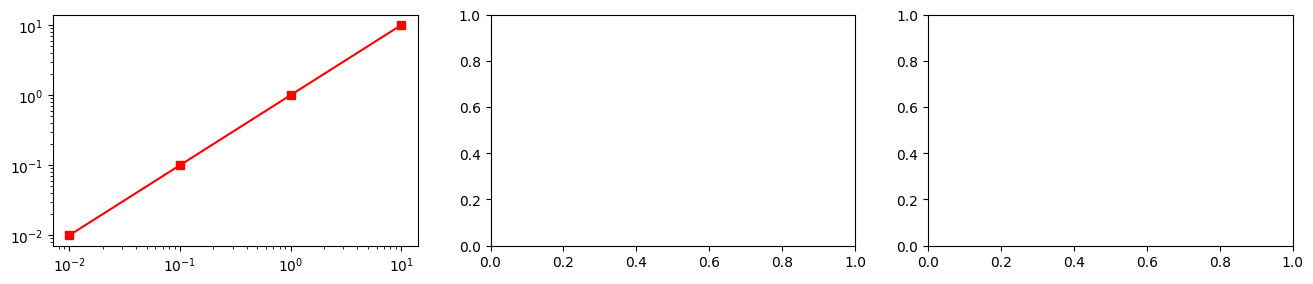

In [ ]:
fig,ax = plt.subplots(ncols=3,figsize=(16,3))

def flux_fct_eta(species, eta_var):
    result = np.ones_like(eta_var)
    for i in range(len(eta_var)):
        var_int = np.array([eta_var[i], kab0, kbc0, kac0, Eab0, Ebc0, Eac0, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, Aac, signA, signB, signC, 11., X0, Xf, n, dx])
        fint = physfcts(var_int)
        A_ooe = diff_flux(rho_a_ooe,fint.Va_out(X),dx)
        B_ooe = diff_flux(rho_b_ooe,fint.Vb_out(X),dx)
        C_ooe = diff_flux(rho_c_ooe,fint.Vc_out(X),dx)
        deltaint = fint.flux_cc(X[4999])-fint.flux_cw(X[4999])
        if species == 'A':
            result[i] = A_ooe[4999]/deltaint
        elif species == 'B':
            result[i] = B_ooe[4999]/deltaint
        elif species == 'C':
            result[i] = C_ooe[4999]/deltaint
    return result

eta_array = np.array([0.01,0.1,1,10.])
ax[0].loglog(eta_array,eta_array,'-', color = ColorCycle[0])
ax[0].loglog(eta_array,flux_fct_eta('A',eta_array),'o', color = ColorCycle[0])
ax[0].loglog(eta_array,flux_fct_eta('B',eta_array),'o', color = ColorCycle[1])
ax[0].loglog(eta_array,flux_fct_eta('C',eta_array),'o', color = ColorCycle[2])
ax[1].loglog(eta_array,flux_fct_eta('A',eta_array),'o', color = ColorCycle[0])
ax[1].loglog(eta_array,flux_fct_eta('B',eta_array),'o', color = ColorCycle[1])
ax[1].loglog(eta_array,flux_fct_eta('C',eta_array),'o', color = ColorCycle[2])
ax[2].loglog(eta_array,flux_fct_eta('A',eta_array),'o', color = ColorCycle[0])
ax[2].loglog(eta_array,flux_fct_eta('B',eta_array),'o', color = ColorCycle[1])
ax[2].loglog(eta_array,flux_fct_eta('C',eta_array),'o', color = ColorCycle[2])

for i in range(3):
    ax[i].tick_params(axis='x', colors='pink')
    ax[i].tick_params(axis='y', colors='pink')
    ax[i].legend()

Could a linear dependency be prettier?

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


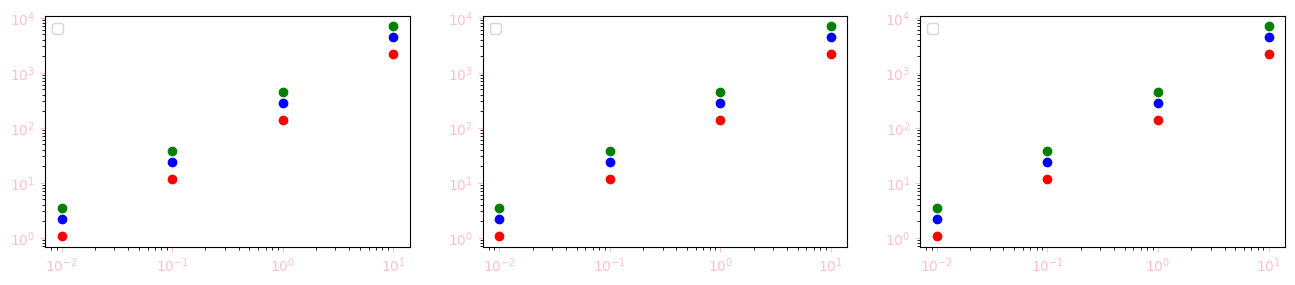

In [ ]:
fig,ax = plt.subplots(ncols=3,figsize=(16,3))

def flux_fct_eta(species, eta_var):
    result = np.ones_like(eta_var)
    for i in range(len(eta_var)):
        var_int = np.array([eta_var[i], kab0, kbc0, kac0, Eab0, Ebc0, Eac0, V0a, V0b, V0c, V1a, V1b, V1c, Aab, Abc, Aac, signA, signB, signC, 11., X0, Xf, n, dx])
        fint = physfcts(var_int)
        A_ooe = diff_flux(rho_a_ooe,fint.Va_out(X),dx)
        B_ooe = diff_flux(rho_b_ooe,fint.Vb_out(X),dx)
        C_ooe = diff_flux(rho_c_ooe,fint.Vc_out(X),dx)
        deltaint = fint.flux_cc(X[4999])-fint.flux_cw(X[4999])
        if species == 'A':
            result[i] = A_ooe[4999]/deltaint
        elif species == 'B':
            result[i] = B_ooe[4999]/deltaint
        elif species == 'C':
            result[i] = C_ooe[4999]/deltaint
    return result

eta_array = np.array([0.01,0.1,1,10.])

ax[0].loglog(eta_array,flux_fct_eta('A',eta_array),'o', color = ColorCycle[0])
ax[0].loglog(eta_array,flux_fct_eta('B',eta_array),'o', color = ColorCycle[1])
ax[0].loglog(eta_array,flux_fct_eta('C',eta_array),'o', color = ColorCycle[2])
ax[1].loglog(eta_array,flux_fct_eta('A',eta_array),'o', color = ColorCycle[0])
ax[1].loglog(eta_array,flux_fct_eta('B',eta_array),'o', color = ColorCycle[1])
ax[1].loglog(eta_array,flux_fct_eta('C',eta_array),'o', color = ColorCycle[2])
ax[2].loglog(eta_array,flux_fct_eta('A',eta_array),'o', color = ColorCycle[0])
ax[2].loglog(eta_array,flux_fct_eta('B',eta_array),'o', color = ColorCycle[1])
ax[2].loglog(eta_array,flux_fct_eta('C',eta_array),'o', color = ColorCycle[2])

for i in range(3):
    ax[i].tick_params(axis='x', colors='pink')
    ax[i].tick_params(axis='y', colors='pink')
    ax[i].legend()